*Antonio Coín Castro*     


# Bayesian Functional Logistic Regression

In [27]:
# -- Libraries

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import arviz as az
import numpy as np
import pandas as pd
from IPython.display import display
import logging
import skfda
import os
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.representation.basis import FDataBasis, Monomial, Fourier
from skfda.representation.grid import FDataGrid
from skfda.ml.classification import (
    MaximumDepthClassifier, KNeighborsClassifier, NearestCentroid)
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
import sys
import pickle
import scipy
from multiprocessing import Pool
import utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the binary $\{0,1\}$-model

$$
\mathbb P(Y=1\mid X=x) = \frac{1}{1 + \exp\{-\alpha_0-\Psi^{-1}_{x}(\alpha)\}},
$$

i.e., each $Y_i$ can be seen as a Bernoulli random variable $\mathcal B(p(x_i))$ with

$$
p(x_i)\equiv p_i=\mathbb P(Y_i=1\mid X_i=x_i) = \frac{1}{1 + \exp\left\{-\alpha_0-\displaystyle\sum_{j=1}^p \beta_jx_i(\tau_j)\right\}}.
$$

Note that $\mathbb E[Y_i]=p_i$ and $\operatorname{Var}(Y_i)=p_i(1-p_i)$.

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)\right]^{-1}\right).
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log \sigma)$, the joint log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \sum_{i=1}^n \left[ \left(\alpha_0 + \Psi^{-1}_{x_i}(\alpha)\right)y_i - \log\left(1 + \exp\left\{\alpha_0 + \Psi_{x_i}^{-1}(\alpha)\right\}\right)\right] +
\frac{1}{2}\log |G_\tau| - p\log \sigma -\frac{1}{2g\sigma^2} (\beta - b_0)'G_\tau(\beta - b_0).  
$$

The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, and a value of $\alpha_0=1$. More precisely, we choose one of

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{-1 + 5X_i(0.1) - 10X_i(0.8)\right\}}\right)
$$

or

$$
Y_i \sim \mathcal B\left(\frac{1}{1 + \exp\left\{-1 -\int_0^1 \beta(t)X_i(t)\, dt\right\}}\right),
$$

where $\beta(t) \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"    # 'L2' or 'RKHS'
STANDARDIZE_PREDICTORS = False
BASIS_REPRESENTATION = True

kernel_fn = utils.fractional_brownian_kernel
beta_coef = utils.cholaquidis_scenario3
basis = Fourier(n_basis=5)

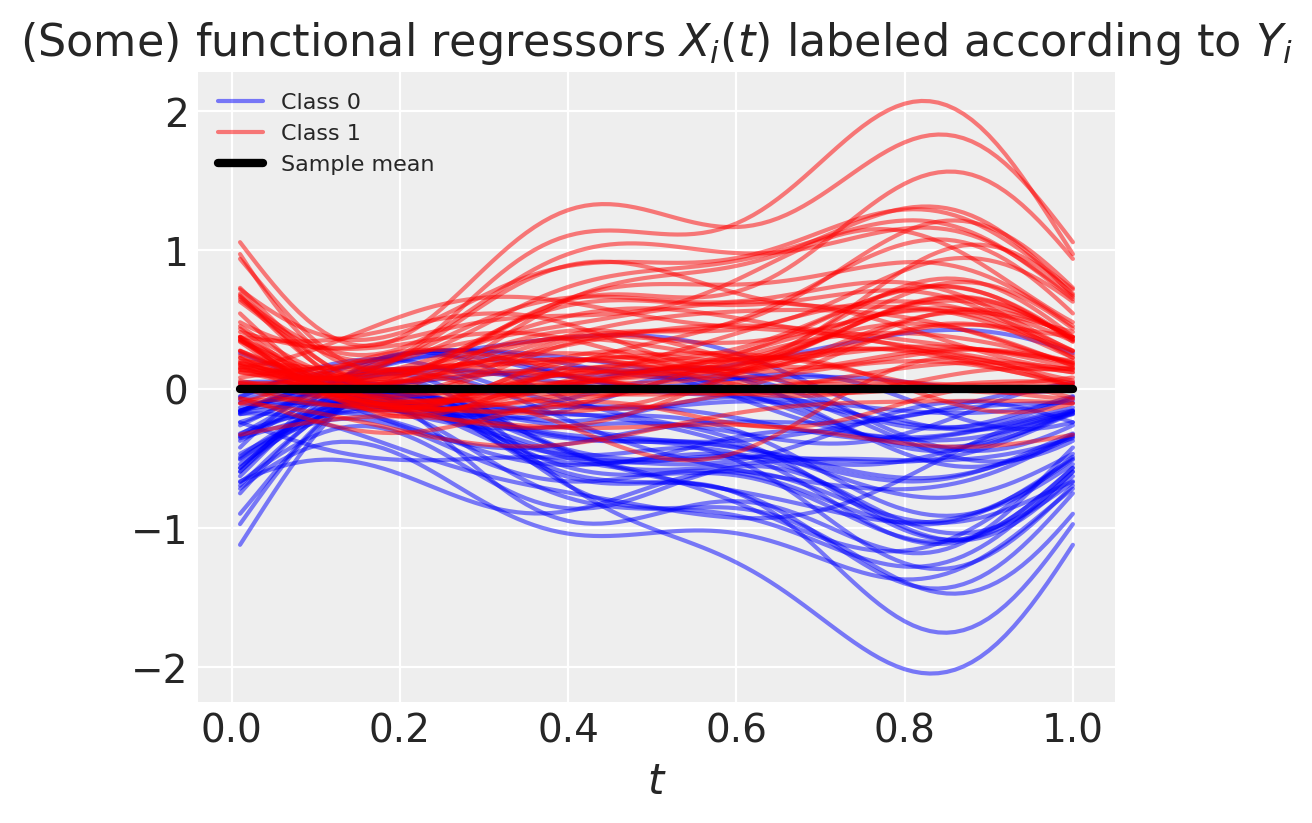

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    n_train, n_test = 100, 100
    N = 100
    grid = np.linspace(1./N, 1., N)

    beta_true = np.array([-5., 10.])
    tau_true = np.array([0.1, 0.8])
    alpha0_true = 1.0

    if MODEL_GEN == "L2":
        X, Y_lin = utils.generate_gp_l2_dataset(
            grid, kernel_fn,
            n_train, beta_coef,
            alpha0_true, 0.0, rng=rng
        )

        X_test, Y_test_lin = utils.generate_gp_l2_dataset(
            grid, kernel_fn,
            n_test, beta_coef,
            alpha0_true, 0.0, rng=rng
        )

    else:
        X, Y_lin = utils.generate_gp_rkhs_dataset(
            grid, kernel_fn,
            n_train, beta_true, tau_true,
            alpha0_true, 0.0, rng=rng
        )

        X_test, Y_test_lin = utils.generate_gp_rkhs_dataset(
            grid, kernel_fn,
            n_test, beta_true, tau_true,
            alpha0_true, 0.0, rng=rng
        )

    # Transform linear response for logistic model
    Y = utils.transform_linear_response(Y_lin, rng)
    Y_test = utils.transform_linear_response(Y_test_lin, rng)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:
    """X_tecator, Y_tecator = skfda.datasets.fetch_tecator(return_X_y=True)
    Y_tecator = Y_tecator[:, 1]  # Fat percentage

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        X_tecator, Y_tecator, train_size=0.8, random_state=SEED)"""

    N = len(X_fd.grid_points[0])
    grid = np.linspace(1./N, 1., N)  # TODO: use (normalized) real grid
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

if BASIS_REPRESENTATION:
    X_fd = X_fd.to_basis(basis).to_grid(X_fd.grid_points[0])
    X_test_fd = X_test_fd.to_basis(basis).to_grid(X_fd.grid_points[0])

if STANDARDIZE_PREDICTORS:
    X_sd = X_fd.data_matrix.std(axis=0)
else:
    X_sd = np.ones(X_fd.data_matrix.shape[1:])

# Standardize data
X_m = X_fd.mean(axis=0)
X_fd = (X_fd - X_m)/X_sd
X = X_fd.data_matrix.reshape(-1, N)
X_test_fd = (X_test_fd - X_m)/X_sd
X_test = X_test_fd.data_matrix.reshape(-1, N)

utils.plot_dataset_classification(X, Y, figsize=(5, 4))

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [5]:
# -- Model hyperparameters

p_hat = 3
TRANSFORM_TAU = False

In [6]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if TRANSFORM_TAU:
    theta_names_ttr = ["β", "logit τ", "α0", "log σ"]
else:
    theta_names_ttr = ["β", "τ", "α0", "log σ"]
theta_names_aux = ["α0 and log σ"]

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]

# Individual labels
theta_labels = []
for i in range(p_hat):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"projection": dict(
        zip(np.arange(p_hat), np.arange(1, p_hat + 1)))}
)

# Dimension of parameter vector
theta_ndim = len(theta_labels)

# Dimension of grouped parameter vector
theta_ndim_grouped = len(theta_names)

# Names of results columns
results_columns = ["Estimator", "Features", "Accuracy"]

In [33]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = utils.Logit()
else:
    tau_ttr = utils.Identity()

# Parameter space
theta_space = utils.ThetaSpace(
    p_hat, grid, theta_names, theta_names_ttr, theta_labels, tau_ttr=tau_ttr)

# Statistics for posterior predictive checks
statistics = [
    ("min", np.min), 
    ("max", np.max), 
    ("median", np.median), 
    ("mean", np.mean), 
    ("std", np.std)]

## Sklearn model comparison

Currently there is a bug when trying to fit an already fitted FPCA object. It checks "if not self.weights" when it should be checking "if self.weights is None" (weights is an ndarray).

In [8]:
# -- Custom CV and transformers

def cv_sk(classifiers, folds, X, Y, X_test, Y_test, verbose=False):
    df_metrics_sk = pd.DataFrame(columns=results_columns)

    for i, (name, pipe, params) in enumerate(classifiers):
        if verbose:
            print(f"Fitting {name}...")
        clf_cv = GridSearchCV(pipe, params, scoring="accuracy",
                              n_jobs=N_CORES, cv=folds)
        clf_cv.fit(X, Y)
        Y_hat = clf_cv.predict(X_test)
        metrics = utils.classification_metrics(Y_test, Y_hat)

        if name == "sk_fknn":
            n_features = f"K={clf_cv.best_params_['clf__n_neighbors']}"
        elif name == "sk_mdc" or name == "sk_fnc":
            n_features = X.data_matrix.shape[1]
        elif "svm" in name:
            n_features = clf_cv.best_estimator_["clf"].n_features_in_
        else:
            if isinstance(clf_cv.best_estimator_["clf"].coef_[0], FDataBasis):
                coef = clf_cv.best_estimator_["clf"].coef_[0].coefficients[0]
            else:
                coef = clf_cv.best_estimator_["clf"].coef_[0]

            n_features = sum(~np.isclose(coef, 0))

        df_metrics_sk.loc[i] = [
            name,
            n_features,
            metrics["acc"]]

        df_metrics_sk.sort_values(
            results_columns[-1], inplace=True, ascending=False)

    return df_metrics_sk


def bayesian_varsel(idata, theta_space, names,
                    X, Y, X_test, Y_test, folds,
                    prefix, point_est='mode',
                    verbose=False):
    grid = theta_space.grid
    p = theta_space.p
    tau_hat = utils.point_estimate(
        idata, point_est, names)[p:2*p]
    idx_hat = np.abs(grid - tau_hat[:, np.newaxis]).argmin(1)

    classifiers_varsel = []

    # Emcee+LR
    classifiers_varsel.append((f"{prefix}_{point_est}+sk_logistic",
                               Pipeline([
                                   ("var_sel", VariableSelection(grid, idx_hat)),
                                   ("data_matrix", DataMatrix()),
                                   ("clf", LogisticRegression(random_state=SEED))]),
                               params_clf
                               ))

    # Emcee+SVM Linear
    classifiers_varsel.append((f"{prefix}_{point_est}+sk_svm_lin",
                               Pipeline([
                                   ("var_sel", VariableSelection(grid, idx_hat)),
                                   ("data_matrix", DataMatrix()),
                                   ("clf", LinearSVC(random_state=SEED))]),
                               params_clf
                               ))

    # Emcee+SVM RBF
    classifiers_varsel.append((f"{prefix}_{point_est}+sk_svm_rbf",
                               Pipeline([
                                   ("var_sel", VariableSelection(grid, idx_hat)),
                                   ("data_matrix", DataMatrix()),
                                   ("clf", SVC(kernel='rbf'))]),
                               {**params_svm, **params_clf}
                               ))

    df_metrics_varsel = cv_sk(classifiers_varsel, folds,
                              X_fd, Y, X_test_fd, Y_test, verbose)

    return df_metrics_varsel


class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, p=1):
        self.p = p

    def fit(self, X, y=None):
        N = X.shape[1]
        self.idx_ = np.linspace(0, N - 1, self.p).astype(int)
        return self

    def transform(self, X, y=None):
        return X[:, self.idx_]


class DataMatrix(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.N = len(X.grid_points[0])
        return self

    def transform(self, X, y=None):
        return X.data_matrix.reshape(-1, self.N)


class Basis(BaseEstimator, TransformerMixin):

    def __init__(self, basis=Fourier()):
        self.basis = basis

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.to_basis(self.basis)


class VariableSelection(BaseEstimator, TransformerMixin):

    def __init__(self, grid=None, idx=None):
        self.grid = grid
        self.idx = idx
        self.idx.sort()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return FDataGrid(X.data_matrix[:, self.idx], self.grid[self.idx])

In [9]:
# -- Select family of classifiers

classifiers = []
Cs = np.logspace(-4, 4, 30)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 6, 10]
n_basis = [3, 5, 7, 9, 11]
basis_fourier = [Fourier(n_basis=p) for p in n_basis]
n_neighbors = [3, 5, 7]

params_clf = {"clf__C": Cs}
params_svm = {"clf__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_fpca = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_fourier}
params_knn = {"clf__n_neighbors": n_neighbors,
              "clf__weights": ['uniform', 'distance']}
params_depth = {"clf__depth_method": [skfda.exploratory.depth.ModifiedBandDepth(),
                                      skfda.exploratory.depth.IntegratedDepth()]}

# Manual+LR
classifiers.append(("manual_sel+sk_logistic",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_clf, **params_select}
                    ))


# FPCA+LR
classifiers.append(("fpca+sk_logistic",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("clf", LogisticRegression(random_state=SEED))]),
                   {**params_fpca, **params_clf}
                    ))

# Manual+SVM Linear
classifiers.append(("manual_sel+sk_svm_lin",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_select, **params_clf}
                    ))

# FPCA+SVM Linear
classifiers.append(("fpca+sk_svm_lin",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("clf", LinearSVC(random_state=SEED))]),
                   {**params_fpca, **params_clf}
                    ))

# Manual+SVM RBF
classifiers.append(("manual_sel+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_select, **params_svm, **params_svm}
                    ))

# FPCA+SVM RBF
classifiers.append(("fpca+sk_svm_rbf",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("clf", SVC(kernel='rbf'))]),
                   {**params_fpca, **params_svm, **params_svm}
                    ))


# Maximum Depth Classifier
classifiers.append(("sk_mdc",
                   Pipeline([
                       ("clf", MaximumDepthClassifier())]),
                   params_depth
                    ))

# KNeighbors Functional Classification
classifiers.append(("sk_fknn",
                   Pipeline([
                       ("clf", KNeighborsClassifier())]),
                   params_knn
                    ))

# Nearest Centroid Functional Classification
classifiers.append(("sk_fnc",
                   Pipeline([
                       ("clf", NearestCentroid())]),
                   {}
                    ))

In [10]:
# -- Fit models and show metrics

folds = KFold(shuffle=True, random_state=SEED)

df_metrics_sk = cv_sk(classifiers, folds,
                      X_fd, Y, X_test_fd, Y_test)
df_metrics_sk.style.hide_index()

 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.


## Maximum Likelihood Estimator

In [11]:
# -- Negative log-likelihood definition in transformed parameter space

def neg_ll(theta_tr, X, Y, theta_space):
    """Transformed parameter vector 'theta_tr' is (β, τ, α0, log σ)."""
    n, N = X.shape
    grid = np.linspace(1./N, 1., N)

    assert len(theta_tr) == theta_space.ndim

    beta, tau, alpha0, _ = theta_space.get_params(theta_tr)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    lin_comp = alpha0 + X_tau@beta

    return -np.sum(lin_comp*Y - np.logaddexp(0, lin_comp))

In [12]:
# -- MLE estimation

method_mle = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
strategy_mle = 'global'

theta_init = theta_space.forward(
    np.array([0.0]*p_hat + [0.5]*p_hat + [0.0] + [1.0]))

if TRANSFORM_TAU:
    bounds = None
else:
    bounds = ([(None, None)]*p_hat
              + [(theta_space.tau_lb, theta_space.tau_ub)]*p_hat
              + [(None, None)]
              + [(None, None)])

if strategy_mle == 'local':
    mle_theta_tr = scipy.optimize.minimize(
        neg_ll,
        x0=theta_init,
        bounds=bounds,
        method=method_mle,
        args=(X, Y, theta_space)
    ).x
    bic = utils.compute_bic(theta_space, neg_ll, mle_theta_tr, X, Y)
elif strategy_mle == 'global':
    mles = np.zeros((N_CORES, theta_space.ndim))

    def optimizer(rng):
        return scipy.optimize.basinhopping(
            neg_ll,
            x0=theta_init,
            seed=rng,
            minimizer_kwargs={"args": (X, Y, theta_space),
                              "method": method_mle,
                              "bounds": bounds}
        ).x

    with Pool(N_CORES) as p:
        print(f"-- Computing MLE with {N_CORES} independent runs --")
        rngs = [np.random.default_rng(SEED + i) for i in range(N_CORES)]
        mles = p.map(optimizer, rngs)
        bics = utils.bic = utils.compute_bic(theta_space, neg_ll, mles, X, Y)
        mle_theta_tr = mles[np.argmin(bics)]
        bic = bics[np.argmin(bics)]
else:
    raise ValueError('Invalid strategy for MLE computation.')

mle_theta = theta_space.backward(mle_theta_tr)
Y_hat_mle = utils.generate_response_logistic(X_test, mle_theta)
df_metrics_mle = pd.DataFrame(columns=results_columns)
metrics_mle = utils.classification_metrics(Y_test, Y_hat_mle)
df_metrics_mle.loc[0] = [
    "mle",
    p_hat,
    metrics_mle["acc"]
]

print(f"\nBIC: {bic:.3f}")
print("MLE:")
display(pd.DataFrame(zip(theta_space.labels, mle_theta),
                     columns=["", "MLE"]).style.hide_index())
print("Classification metrics:")
df_metrics_mle.style.hide_index()

-- Computing MLE with 4 independent runs --

BIC: 68.530
MLE:


Classification metrics:


## The Ensemble Sampler and the *emcee* library

In [13]:
import emcee

### Model

We only need to provide the sampler with the logarithm of the posterior distribution. For clarity we split up its computation in log-prior and log-likelihood, although for a more efficient implementation it should all be in one function. 

In [14]:
# -- Log-posterior model

def log_prior(theta_tr):
    """Global parameters (for efficient parallelization): 
        X, b0, g, eta, theta_space"""
    assert len(theta_tr) == theta_space.ndim

    n, N = X.shape
    p = theta_space.p
    grid = theta_space.grid

    theta = theta_space.backward(theta_tr)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta)
    log_sigma = theta_space.get_sigma2(theta_tr)

    if not TRANSFORM_TAU:
        if (tau < theta_space.tau_lb).any() or (tau > theta_space.tau_ub).any():
            return -np.inf

    # Transform variables
    b = beta - b0

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 - p*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma2))

    return log_prior


def log_likelihood(theta_tr, Y):
    """Global parameters (for efficient parallelization): X"""
    return -neg_ll(theta_tr, X, Y, theta_space)


def log_posterior(theta_tr, Y):
    """Global parameters (for efficient parallelization): X, rng, return_pps"""
    lp = log_prior(theta_tr)

    if not np.isfinite(lp):
        if return_pps:
            return -np.inf, np.full_like(Y, -np.inf)
        else:
            return -np.inf

    ll = log_likelihood(theta_tr, Y)
    lpos = lp + ll

    if return_pps:
        theta = theta_space.backward(theta_tr)
        Y_lin = utils.generate_response(X, theta, noise=False)
        pps = utils.generate_response_logistic(X, theta, rng=rng)
        return lpos, pps
    else:
        return lpos

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [18]:
def run_emcee(n_walkers, n_iter_initial, n_iter, moves,
              thin, thin_ppc, return_pps, point_est_varsel='mode'):
    # -- Run sampler

    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior,
            pool=pool, args=(Y,),
            moves=moves)

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

    logging.disable(sys.maxsize)  # Disable logger

    # Analyze autocorrelation and set burn-in and thinning values
    autocorr = sampler.get_autocorr_time(quiet=True)
    max_autocorr = np.max(autocorr)
    if (np.isfinite(autocorr)).all():
        burn = int(3*max_autocorr)
    else:
        print("Some autocorrelation value is not finite")
        burn = 500

    logging.disable(logging.NOTSET)  # Re-enable logger

    # Get InferenceData object
    idata_emcee = utils.emcee_to_idata(
        sampler, theta_space, burn, thin, return_pps)

    print("\n-- Summary statistics --")
    display(utils.summary(idata_emcee, var_names=theta_names,
                          kind="stats", labeller=theta_labeller))

    # -- Compute metrics using several point estimates

    point_estimates = ["mode", "mean", "median"]
    df_metrics_emcee = pd.DataFrame(columns=results_columns)

    # Posterior mean estimate
    ppc_test = utils.generate_ppc(
        idata_emcee, X_test, theta_names,
        thin_ppc, rng=rng,
        kind='classification')
    Y_hat = [utils.threshold(y) for y in ppc_test.mean(axis=(0, 1))]
    metrics = utils.classification_metrics(Y_test, Y_hat)
    df_metrics_emcee.loc[0] = [
        "emcee_posterior_mean",
        p_hat,
        metrics["acc"]
    ]

    # Point estimates
    for i, pe in enumerate(point_estimates):
        Y_hat = utils.point_predict(
            X_test, idata_emcee,
            theta_names, pe,
            kind='classification')
        metrics = utils.classification_metrics(Y_test, Y_hat)
        df_metrics_emcee.loc[i + 1] = [
            "emcee_" + pe,
            p_hat,
            metrics["acc"]
        ]

    # Bayesian variable selection
    df_metrics_varsel = bayesian_varsel(
        idata_emcee, theta_space, theta_names, X_fd,
        Y, X_test_fd, Y_test, folds, prefix="emcee",
        point_est=point_est_varsel,
        )

    df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)
    df_metrics_emcee = df_metrics_emcee.append(df_metrics_mle)
    df_metrics_emcee = df_metrics_emcee.append(df_metrics_varsel)
    df_metrics_emcee.sort_values(
        results_columns[-1], inplace=True, ascending=False)
    print("-- Classification metrics --")
    display(df_metrics_emcee.style.hide_index())

    return sampler, idata_emcee

In [19]:
# -- Sampler parameters

g = 5
eta = 0.01

n_walkers = 64
n_iter_initial = 100
n_iter = 1000
return_pps = True
frac_random = 0.3

sd_beta_init = 1.0
sd_tau_init = 0.2
mean_alpha0_init = Y.mean()
sd_alpha0_init = 1.0
param_sigma2_init = 2.0  # shape parameter in inv_gamma distribution
sd_sigma2_init = 1.0

moves = [
    (emcee.moves.StretchMove(), 1.0)
]

thin = 1
thin_ppc = 5

FAST_RUN = True

# Start every walker in a (random) neighbourhood around the MLE
p0 = utils.weighted_initial_guess_around_value(
    theta_space, mle_theta_tr, sd_beta_init, sd_tau_init,
    mean_alpha0_init, sd_alpha0_init, param_sigma2_init,
    sd_sigma2_init, n_walkers=n_walkers, rng=rng,
    frac_random=frac_random)

b0 = mle_theta_tr[theta_space.beta_idx]

In [20]:
# -- Run sampler

if FAST_RUN:
    sampler, idata_emcee = run_emcee(
        n_walkers, n_iter_initial, n_iter, moves, thin, thin_ppc, return_pps)
else:
    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior,
            pool=pool, args=(Y,),
            moves=moves)

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/100 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean acceptance fraction: 23.659%

-- Summary statistics --


mean         sd  hdi_3%  hdi_97%      mode  median
β[1]           2.467      3.220  -4.220    9.400     2.706   2.642
β[2]          -7.437      6.347 -15.146    8.473   -10.609 -10.154
β[3]          11.319      6.494  -8.247   17.454    13.892  13.647
τ[1]           0.484      0.282   0.000    0.926     0.001   0.483
τ[2]           0.178      0.245   0.000    0.799     0.040   0.078
τ[3]           0.760      0.199   0.272    0.994     0.790   0.807
$\alpha_0$     0.775      0.504  -0.147    1.730     0.777   0.767
$\sigma^2$  3623.157  50643.183   0.002  604.853  1215.702   2.474

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

-- Classification metrics --


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [28]:
# -- Sampler statistics and trace (with burn-in and thinning)

logging.disable(sys.maxsize)  # Disable logger

# Analyze autocorrelation and set burn-in and thinning values
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
if (np.isfinite(autocorr)).all():
    burn = int(3*max_autocorr)
else:
    print("Some autocorrelation value is not finite")
    burn = 500

# Get trace of samples
trace_flat = utils.get_trace_emcee(sampler, theta_space, burn, thin, flat=True)

# Get InferenceData object
idata_emcee = utils.emcee_to_idata(
    sampler, theta_space, burn, thin, return_pps)

# Update and show autocorrelation
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)

logging.disable(logging.NOTSET)  # Re-enable logger

pd.DataFrame(
    zip(theta_labels, autocorr_thin, len(trace_flat)/autocorr_thin),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

In [29]:
utils.summary(idata_emcee, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean         sd  hdi_3%  hdi_97%      mode  median
β[1]           2.467      3.220  -4.220    9.400     2.706   2.642
β[2]          -7.437      6.347 -15.146    8.473   -10.609 -10.154
β[3]          11.319      6.494  -8.247   17.454    13.892  13.647
τ[1]           0.484      0.282   0.000    0.926     0.001   0.483
τ[2]           0.178      0.245   0.000    0.799     0.040   0.078
τ[3]           0.760      0.199   0.272    0.994     0.790   0.807
$\alpha_0$     0.775      0.504  -0.147    1.730     0.777   0.767
$\sigma^2$  3623.157  50643.183   0.002  604.853  1215.702   2.474

Combined density and trace plot:


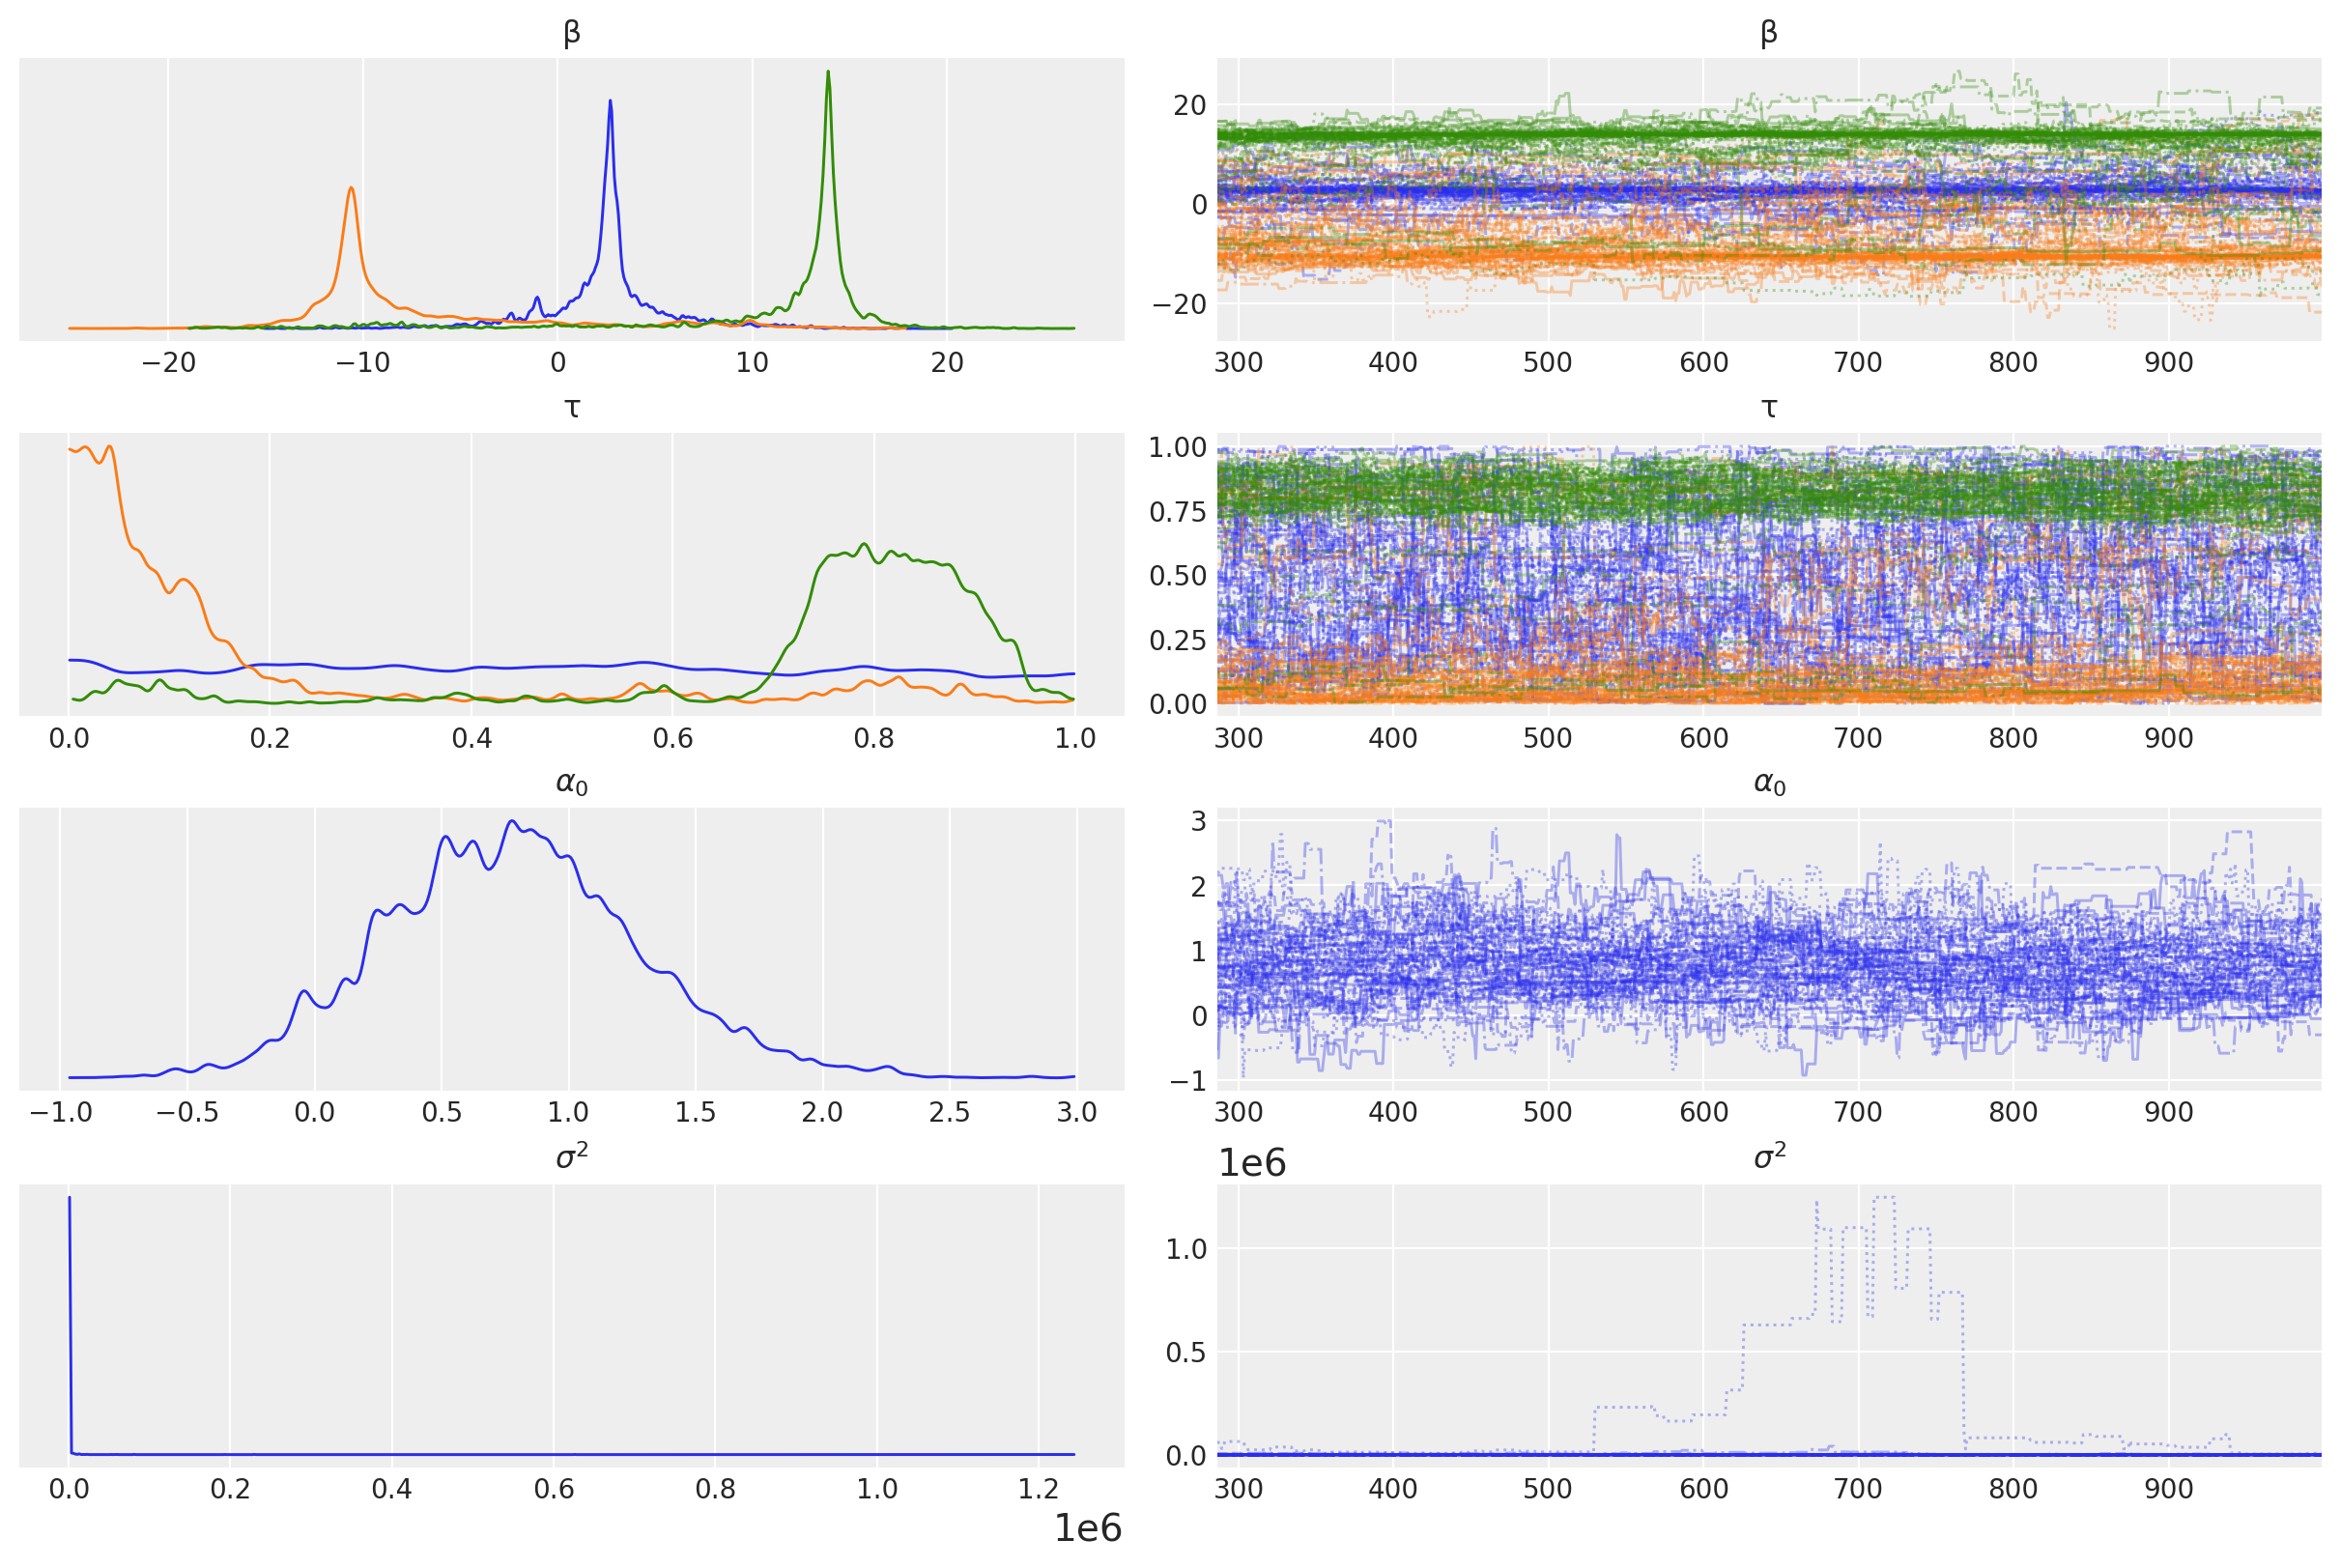

In [30]:
az.plot_trace(idata_emcee, labeller=theta_labeller,
              combined=True, var_names=theta_names)
print("Combined density and trace plot:")

Marginal posterior distributions:


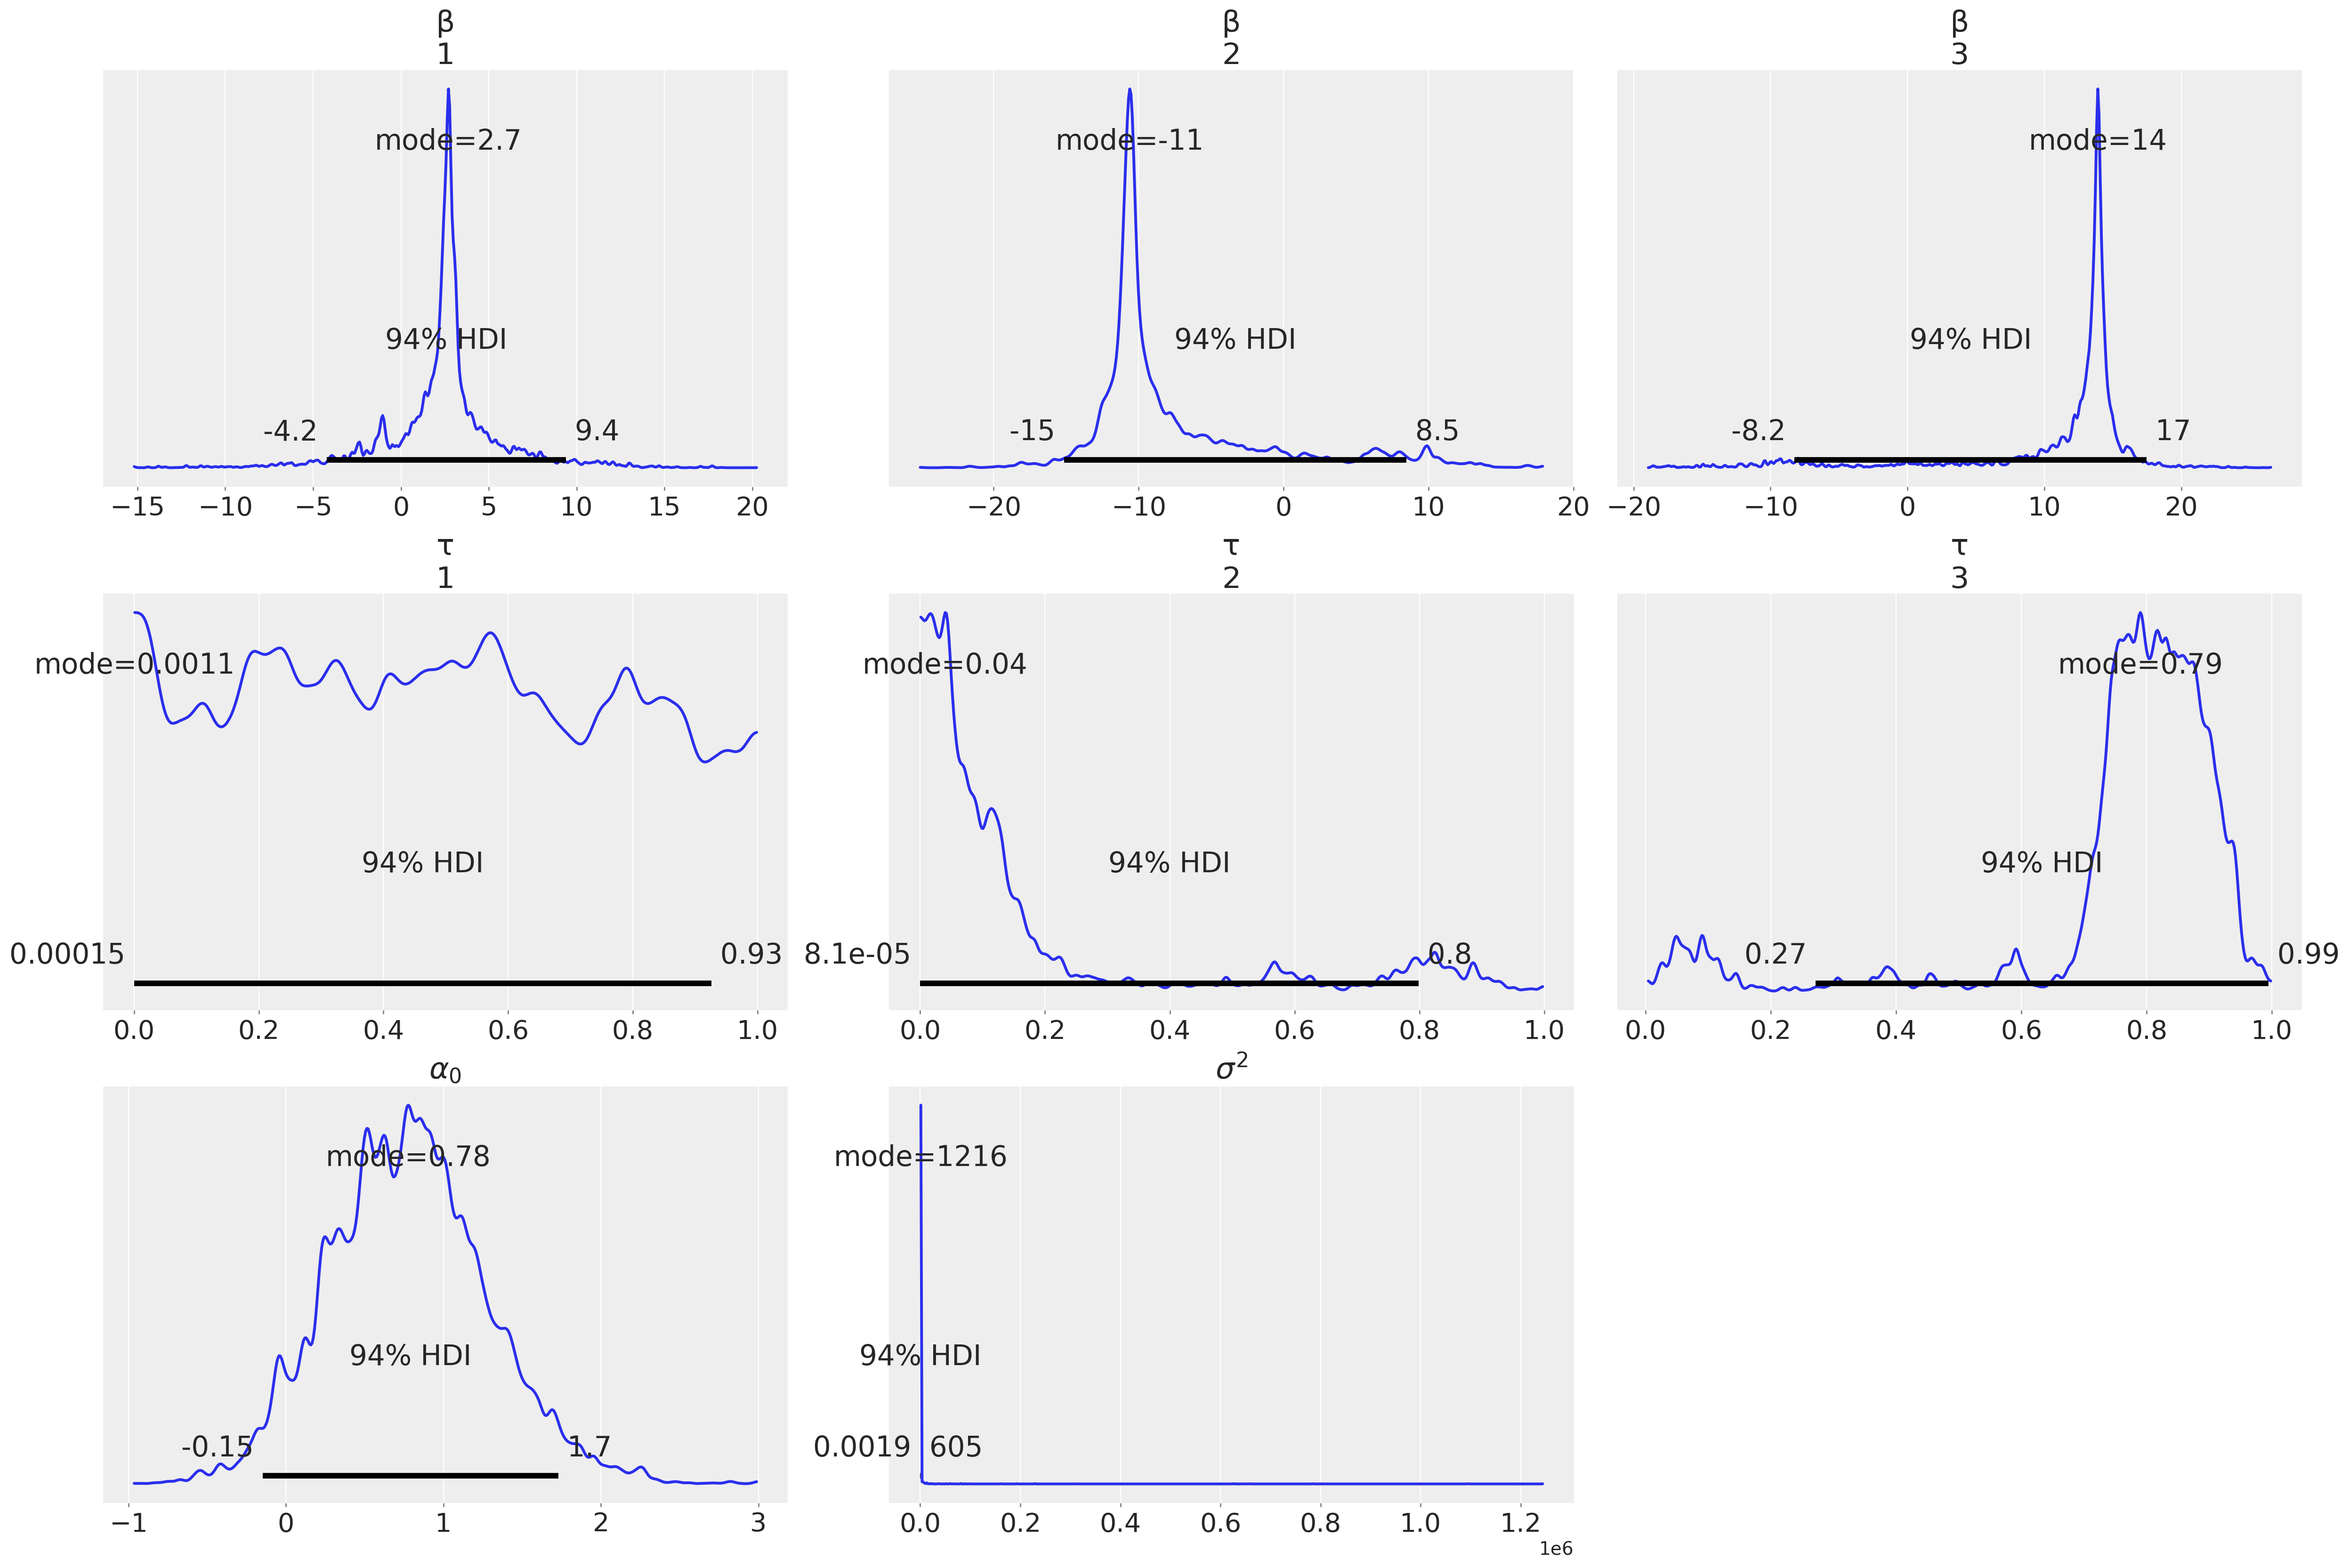

In [31]:
az.plot_posterior(idata_emcee, labeller=theta_labeller, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20,
                  var_names=theta_names)
print("Marginal posterior distributions:")

bpv [min] = 1.000
bpv [max] = 1.000
bpv [median] = 1.000
bpv [mean] = 0.548
bpv [std] = 0.594


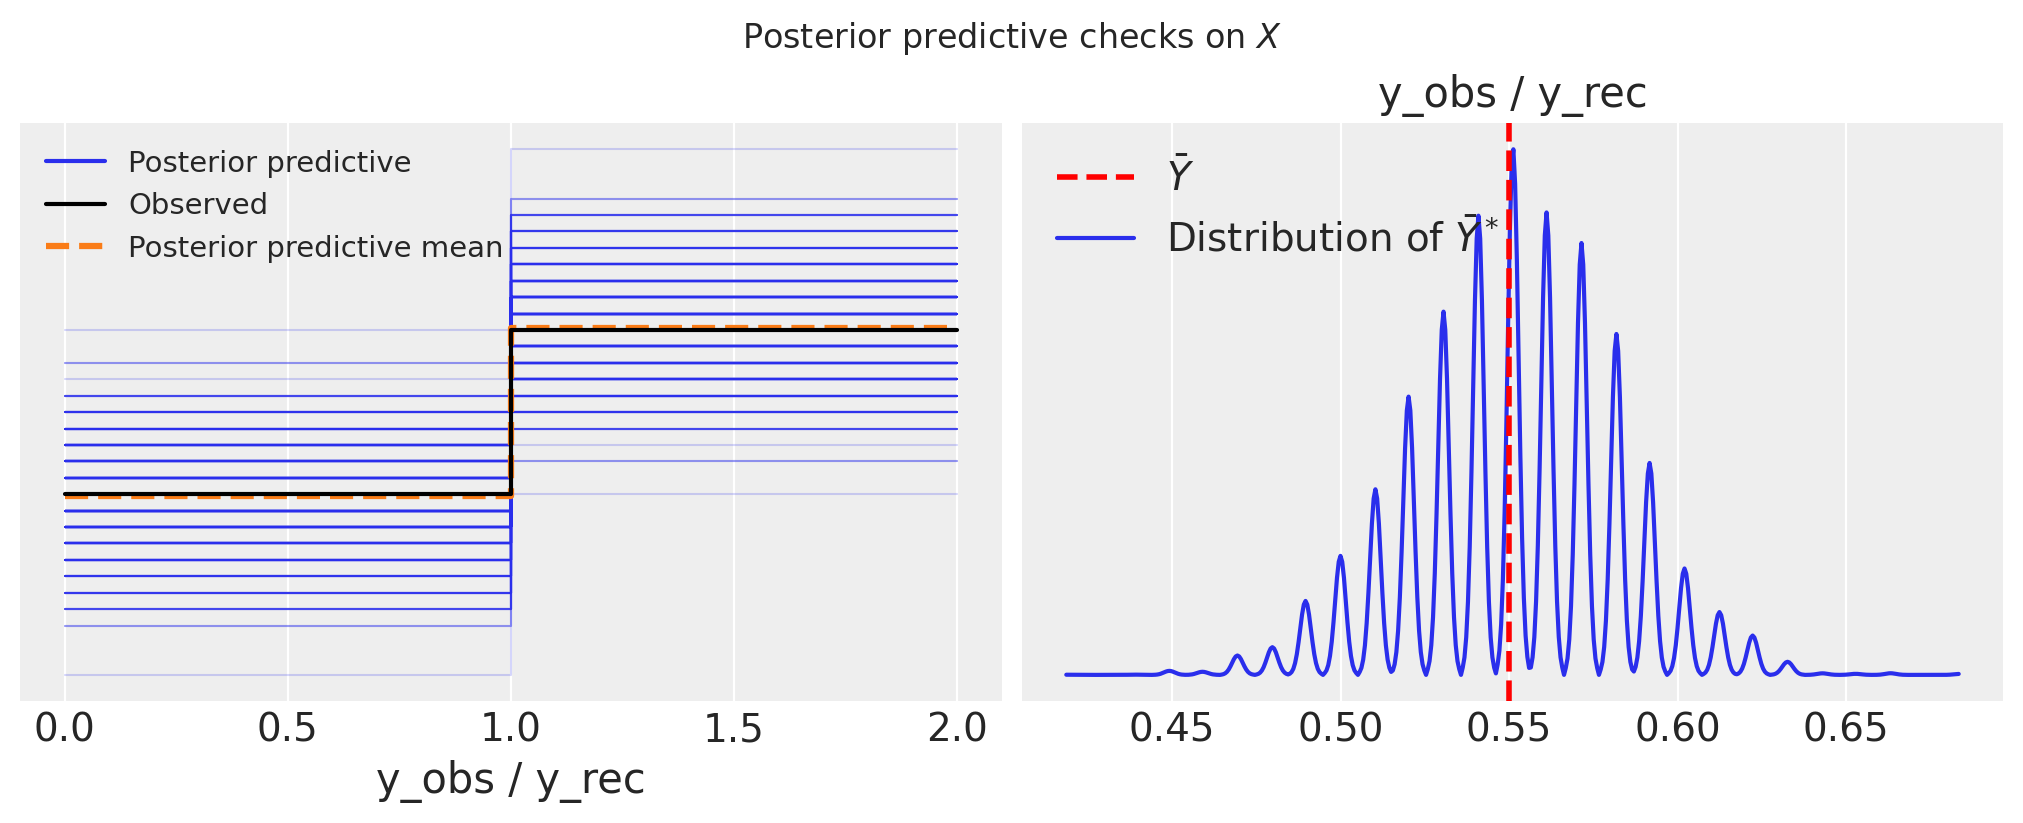

In [34]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    ppc = utils.generate_ppc(idata_emcee, X, theta_names,
                             rng=rng, kind='classification')
    idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_rec")
else:
    ppc = idata_emcee.posterior_predictive['y_rec'].to_numpy()
    idata_ppc = idata_emcee

#TODO
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={
               'y_obs': 'y_rec'}, ax=axs[0])
az.plot_bpv(idata_ppc, kind='t_stat', t_stat='mean', data_pairs={
            'y_obs': 'y_rec'}, plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
axs[1].legend(handles=handles)
plt.suptitle(r"Posterior predictive checks on $X$")

for name, stat in statistics:
    bpv = utils.bpv(ppc, Y, stat)
    print(f"bpv [{name}] = {bpv:.3f}")

Combined autocorrelation times:


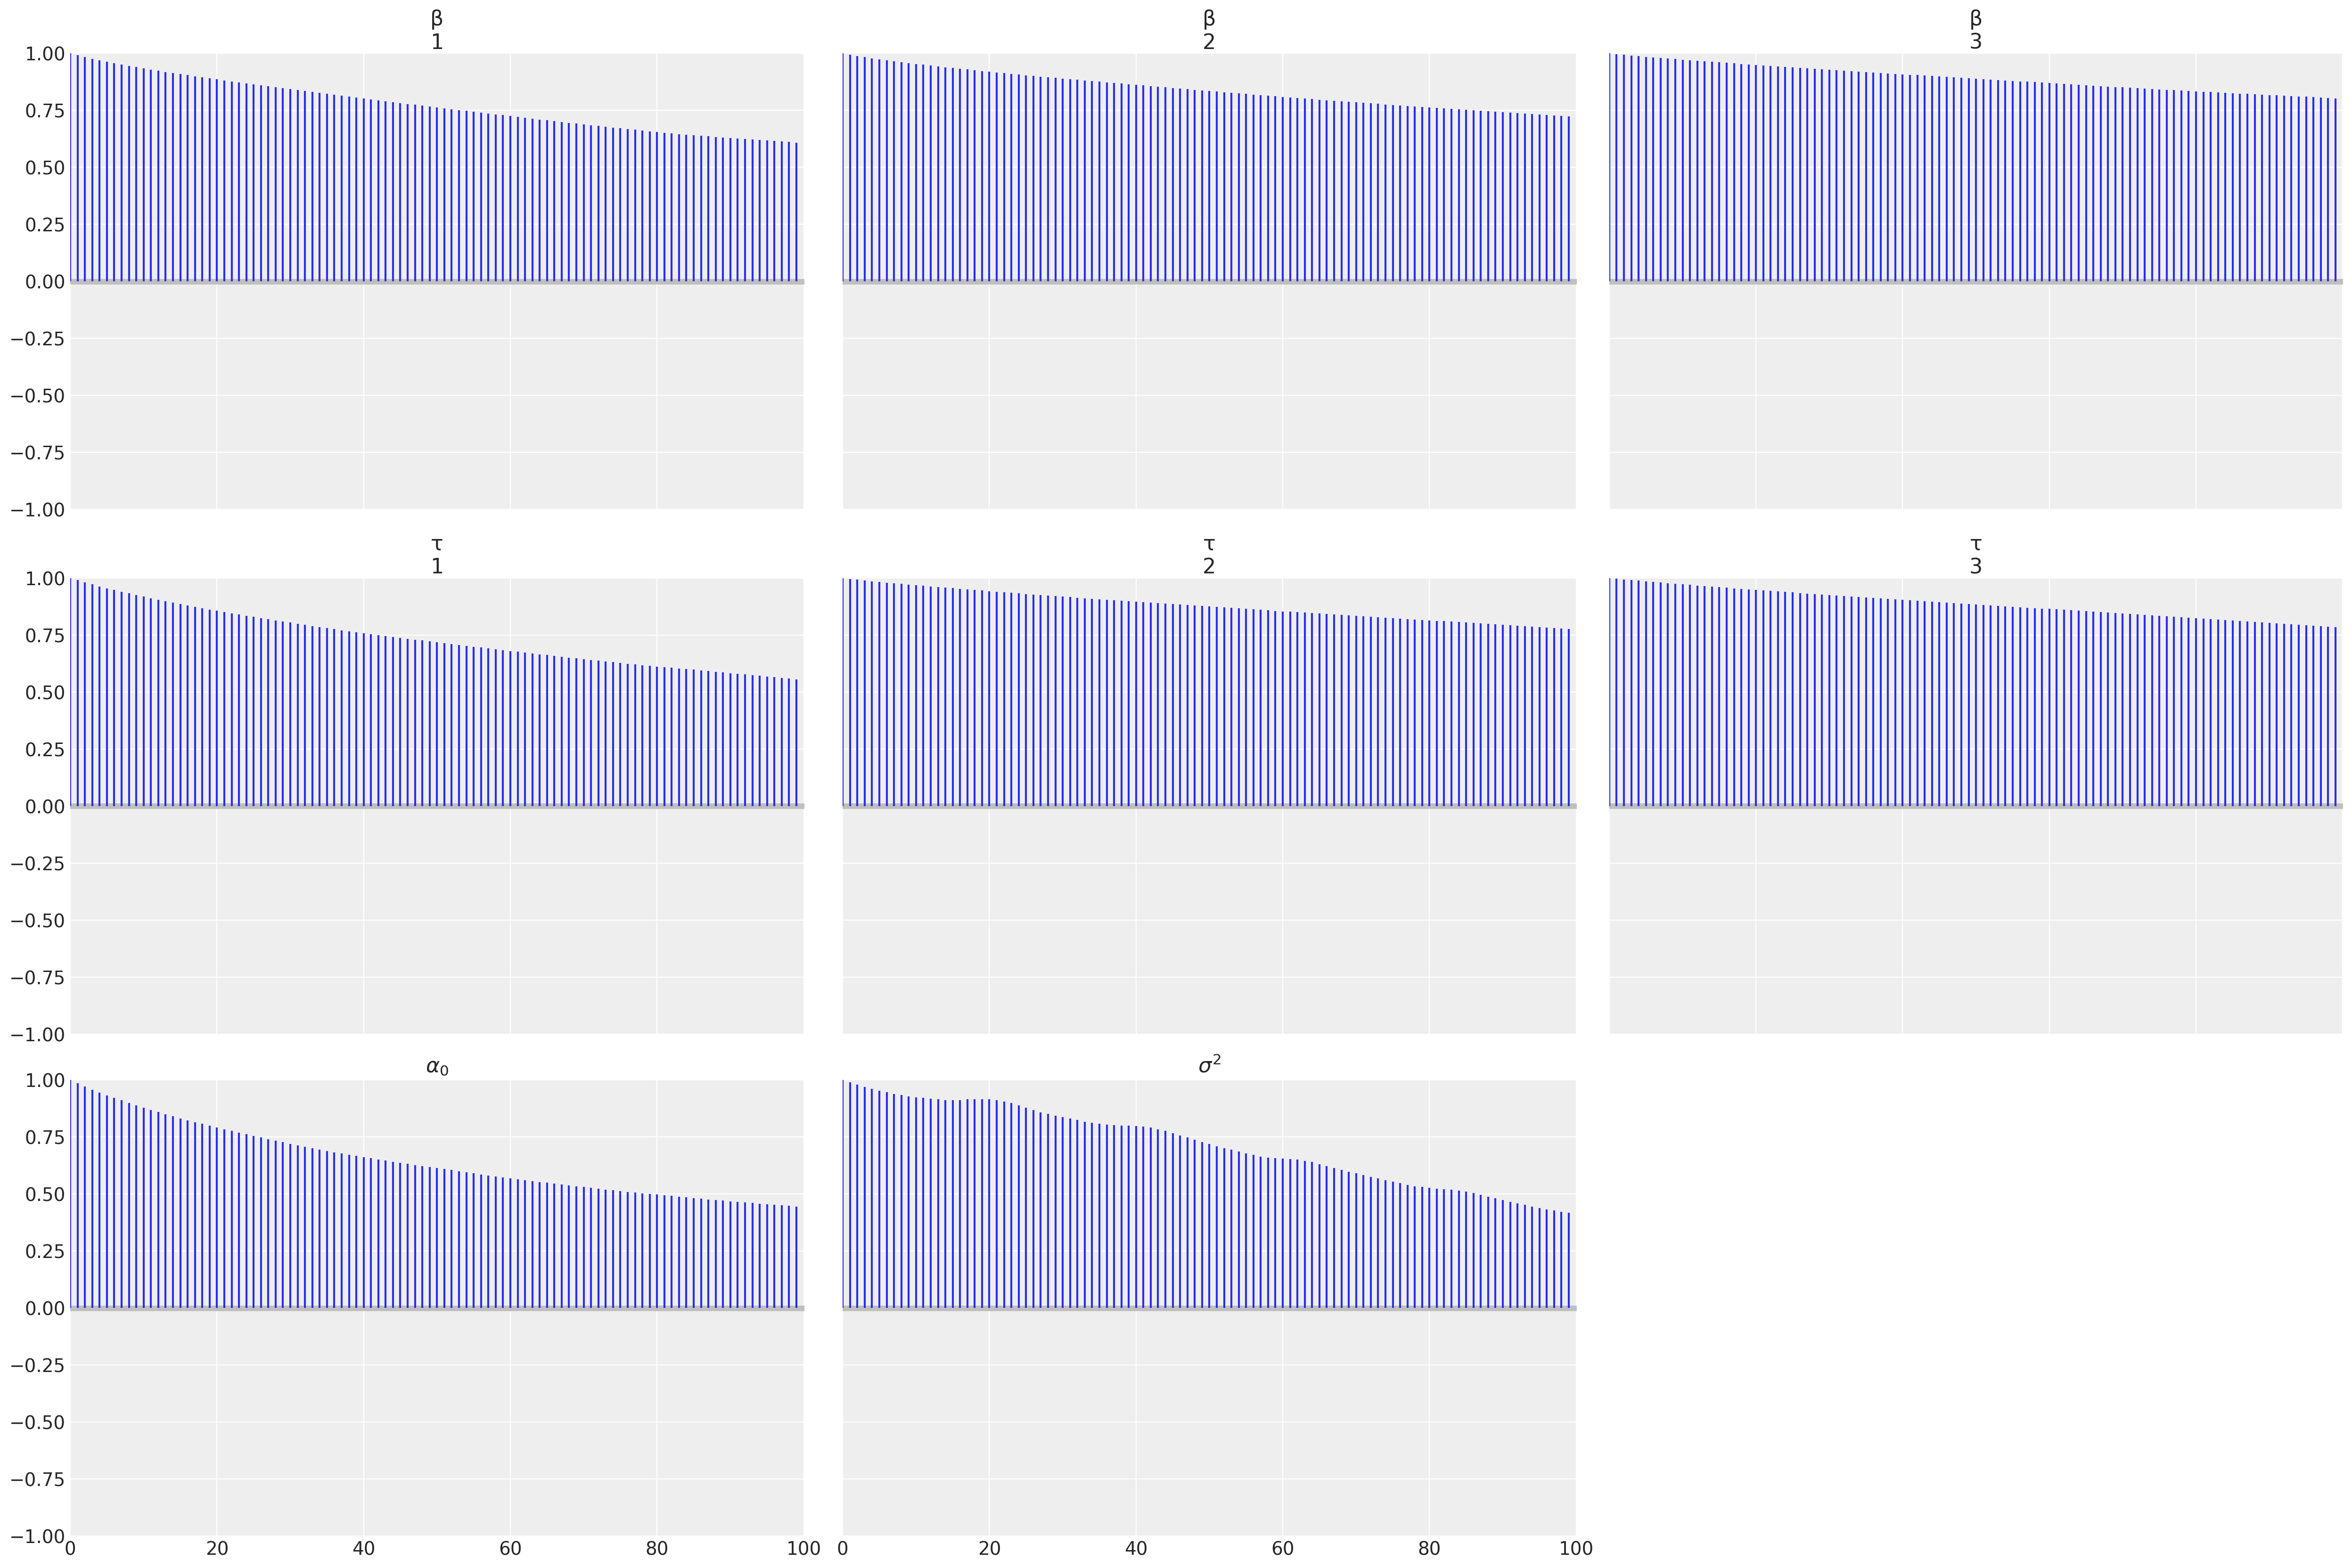

In [35]:
az.plot_autocorr(idata_emcee, combined=True, var_names=theta_names,
                 grid=(NROWS(theta_ndim), NCOLS), labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

bpv [min] = 1.000
bpv [max] = 1.000
bpv [median] = 1.000
bpv [mean] = 0.941
bpv [std] = 0.106


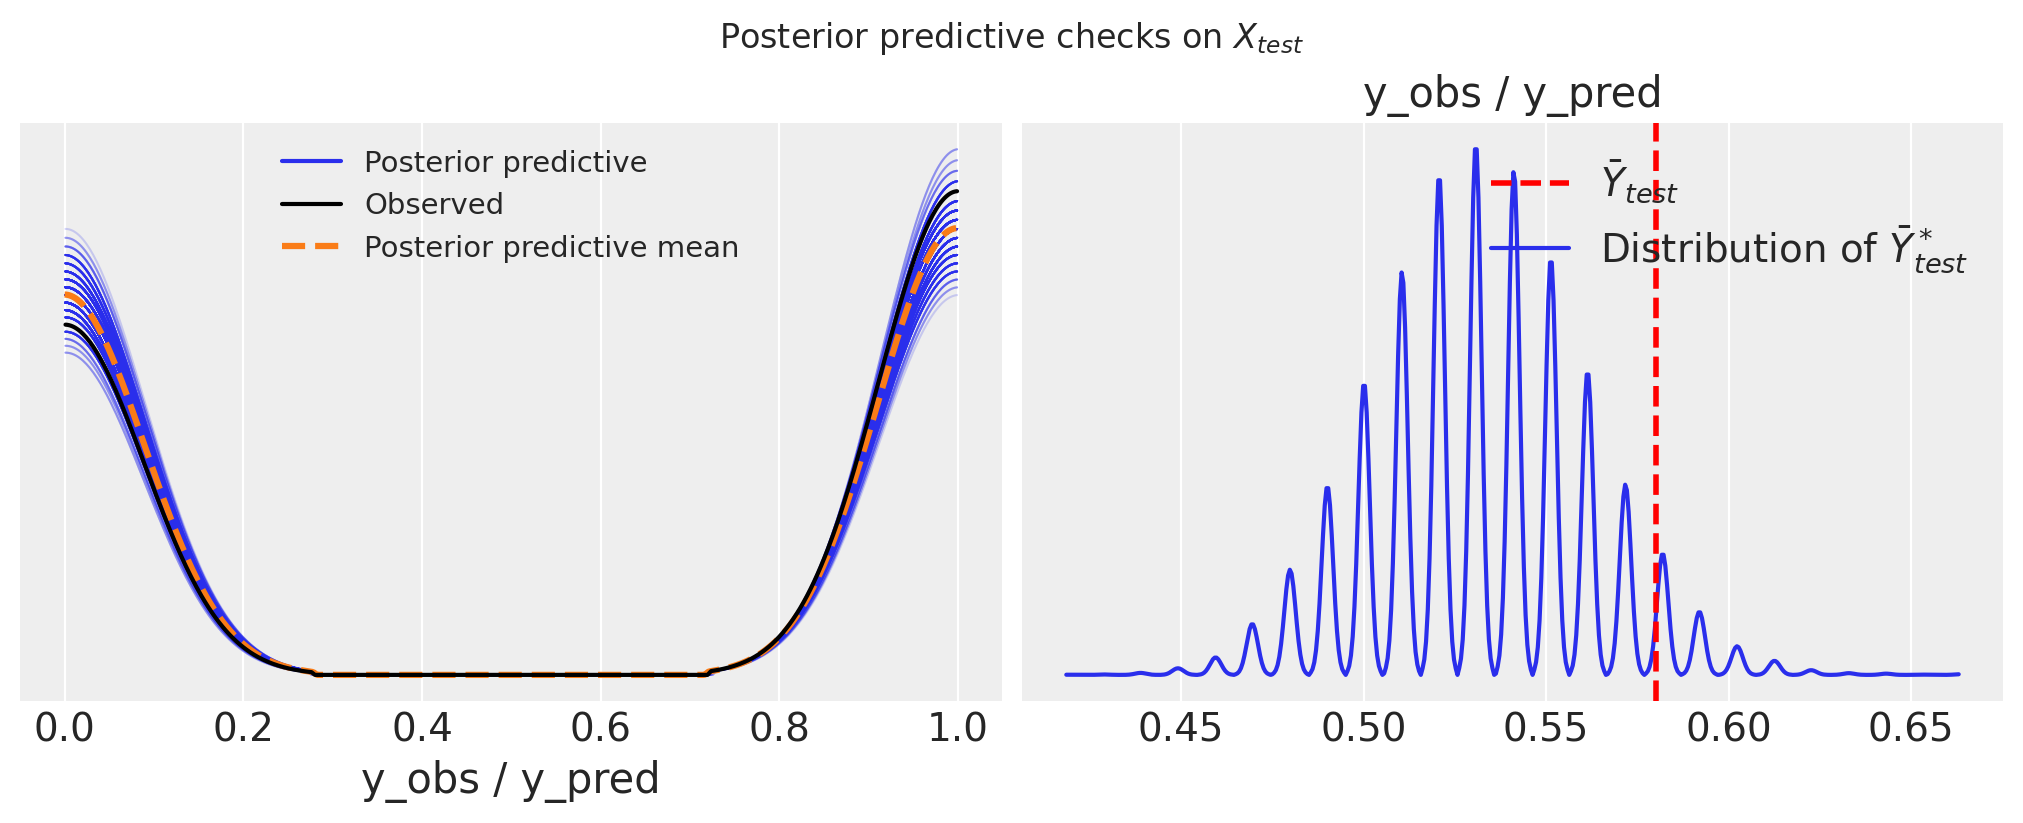

In [36]:
# -- Generate and plot posterior predictive samples from X_test

ppc_test = utils.generate_ppc(idata_emcee, X_test, theta_names,
                              rng=rng, kind='classification')
idata_ppc_test = utils.ppc_to_idata(
    ppc_test, idata_emcee, "y_pred", y_obs=Y_test)

# TODO
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
utils.plot_ppc(idata_ppc_test, n_samples=500, data_pairs={
               'y_obs': 'y_pred'}, ax=axs[0])
az.plot_bpv(idata_ppc_test, kind='t_stat', t_stat='mean', data_pairs={
            'y_obs': 'y_pred'}, plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y_test.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*_{test}$")])
_ = axs[1].legend(handles=handles)
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

for name, stat in statistics:
    bpv = utils.bpv(ppc_test, Y_test, stat)
    print(f"bpv [{name}] = {bpv:.3f}")

In [37]:
# -- Compute metrics using several point estimates

point_estimates = ["mode", "mean", "median"]
df_metrics_emcee = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat = [utils.threshold(y)
         for y in ppc_test[:, ::thin_ppc, :].mean(axis=(0, 1))]
metrics = utils.classification_metrics(Y_test, Y_hat)
df_metrics_emcee.loc[0] = [
    "emcee_posterior_mean",
    p_hat,
    metrics["acc"]
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat = utils.point_predict(
        X_test, idata_emcee,
        theta_names, pe, kind='classification')
    metrics = utils.classification_metrics(Y_test, Y_hat)
    df_metrics_emcee.loc[i + 1] = [
        "emcee_" + pe,
        p_hat,
        metrics["acc"],
    ]

df_metrics_emcee.sort_values(
    results_columns[-1], inplace=True, ascending=False)
df_metrics_emcee.style.hide_index()

In [38]:
# -- Test variable selection procedure

bayesian_varsel(idata_emcee, theta_space, theta_names, X_fd,
                Y, X_test_fd, Y_test, folds, prefix="emcee",
                point_est='mode')

Estimator Features  Accuracy
0  emcee_mode+sk_logistic        3      0.95
1   emcee_mode+sk_svm_lin        3      0.95
2   emcee_mode+sk_svm_rbf        3      0.95

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [ ]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [ ]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [39]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

In [40]:
# -- Probabilistic model

def make_model(p, g, eta, X, Y, names, names_aux, mle_theta=None):
    n, N = X.shape
    grid = np.linspace(1./N, 1., N)

    if mle_theta is not None:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        px = pm.math.invlogit(alpha0 + pm.math.matrix_dot(X_tau, beta))

        y_obs = pm.Bernoulli('y_obs', p=px, observed=Y)

    return model

### Experiments

In [41]:
# -- Hyperparameters

burn = 0
thin = 1

In [42]:
# -- NUTS with auto initialization

model = make_model(p_hat, g, eta, X, Y, theta_names,
                   theta_names_aux[:1], mle_theta_tr)

with model:
    idata_pymc = pm.sample(1000, cores=2, tune=2000,
                           target_accept=0.85,
                           return_inferencedata=True)

    idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, τ, α0 and log σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 543 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

Graphical model:


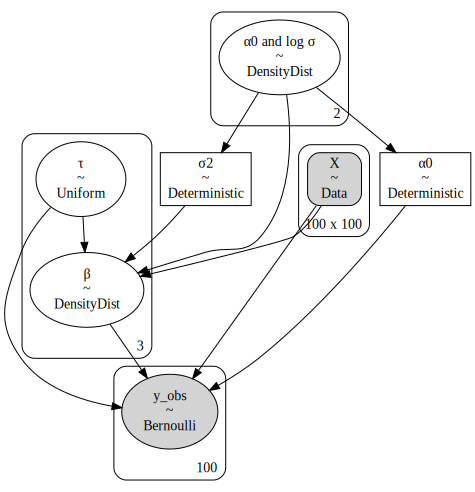

In [43]:
print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

In [44]:
utils.summary(idata_pymc, var_names=theta_names, labeller=theta_labeller)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]         2.720  0.000   2.720    2.721      0.000    0.000     129.0   
β[1]       -10.682  0.000 -10.683  -10.682      0.000    0.000      26.0   
β[2]        13.899  0.000  13.899   13.899      0.000    0.000      30.0   
τ[0]         0.543  0.275   0.084    0.991      0.026    0.021     101.0   
τ[1]         0.437  0.411   0.013    0.999      0.050    0.037      92.0   
τ[2]         0.827  0.071   0.706    0.940      0.008    0.006      76.0   
$\alpha_0$   0.691  0.505  -0.167    1.735      0.062    0.046      69.0   
$\sigma^2$   0.000  0.000   0.000    0.000      0.000    0.000       8.0   

            ess_tail  r_hat    mode  median  
β[0]            67.0   1.18   2.720   2.720  
β[1]            24.0   1.22 -10.682 -10.682  
β[2]            33.0   1.22  13.899  13.899  
τ[0]           102.0   1.01   0.861   0.542  
τ[1]           342.0   1.03   0.001   0.167  
τ[2]           145.0   1.02   0.873   0.838  
$\alpha_0$      95.0   1.04   0.687   0.666  
$\sigma^2$      69.0   1.22   0.000   0.000

Density and trace plot:


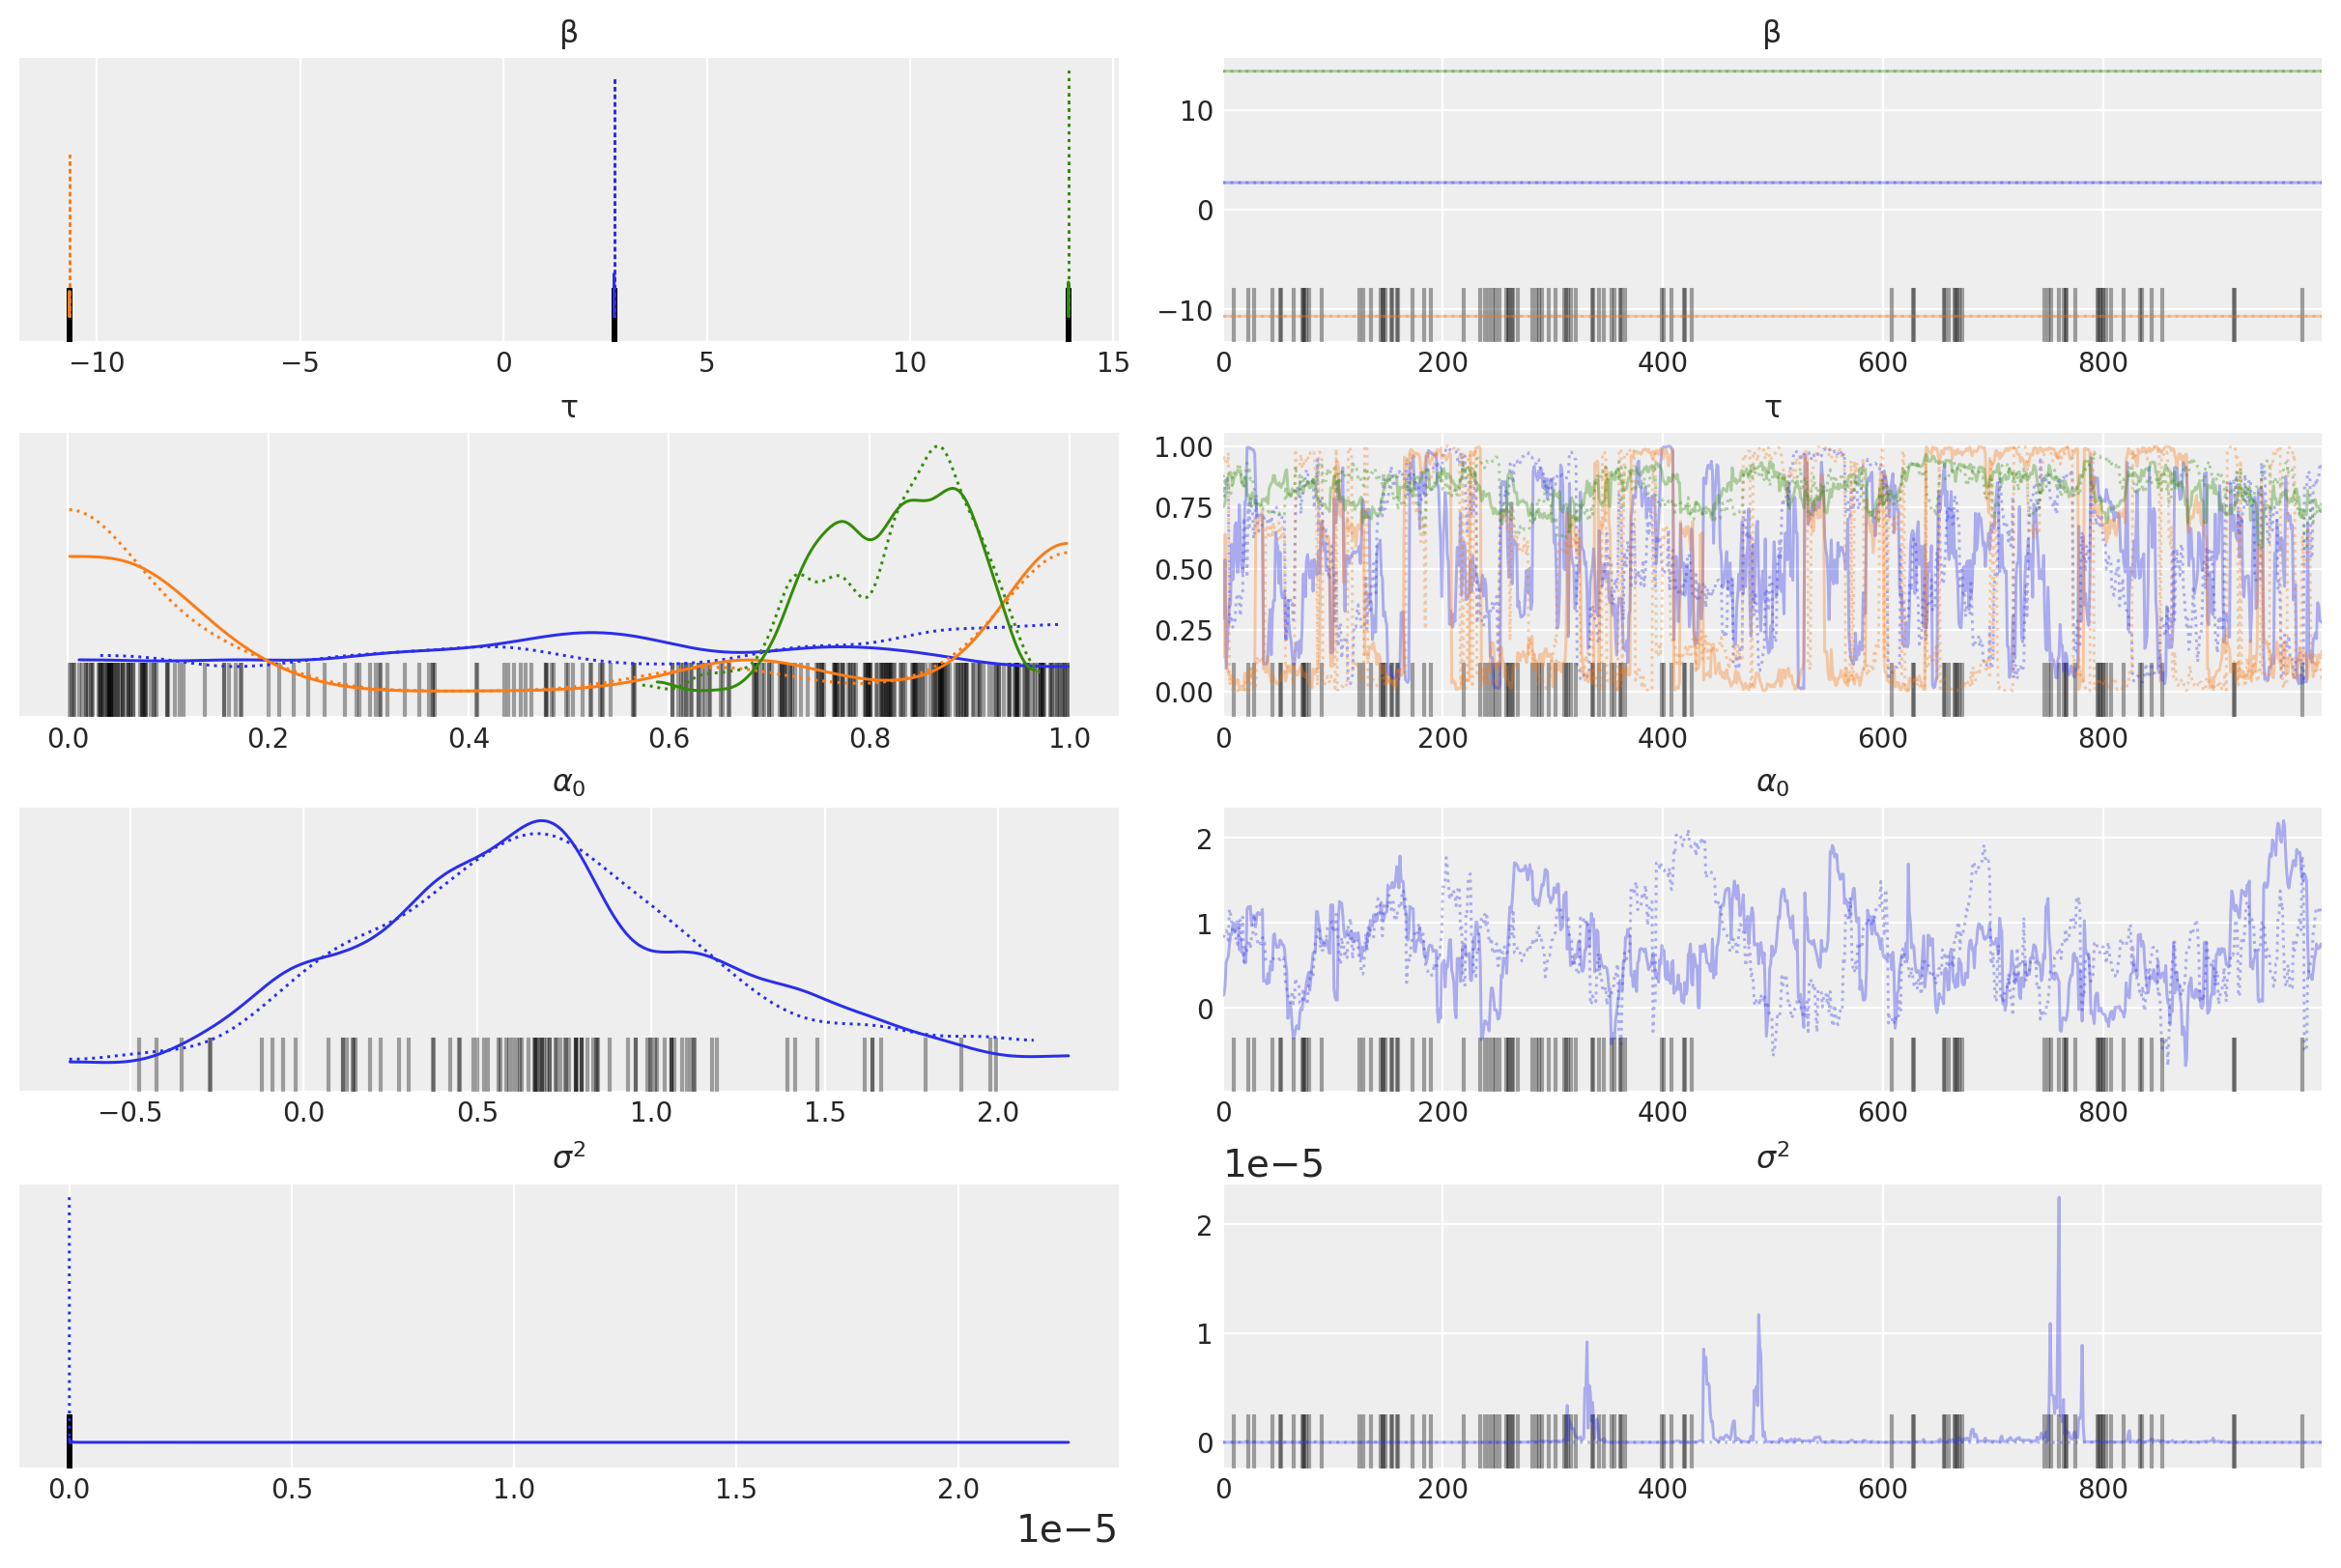

In [45]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


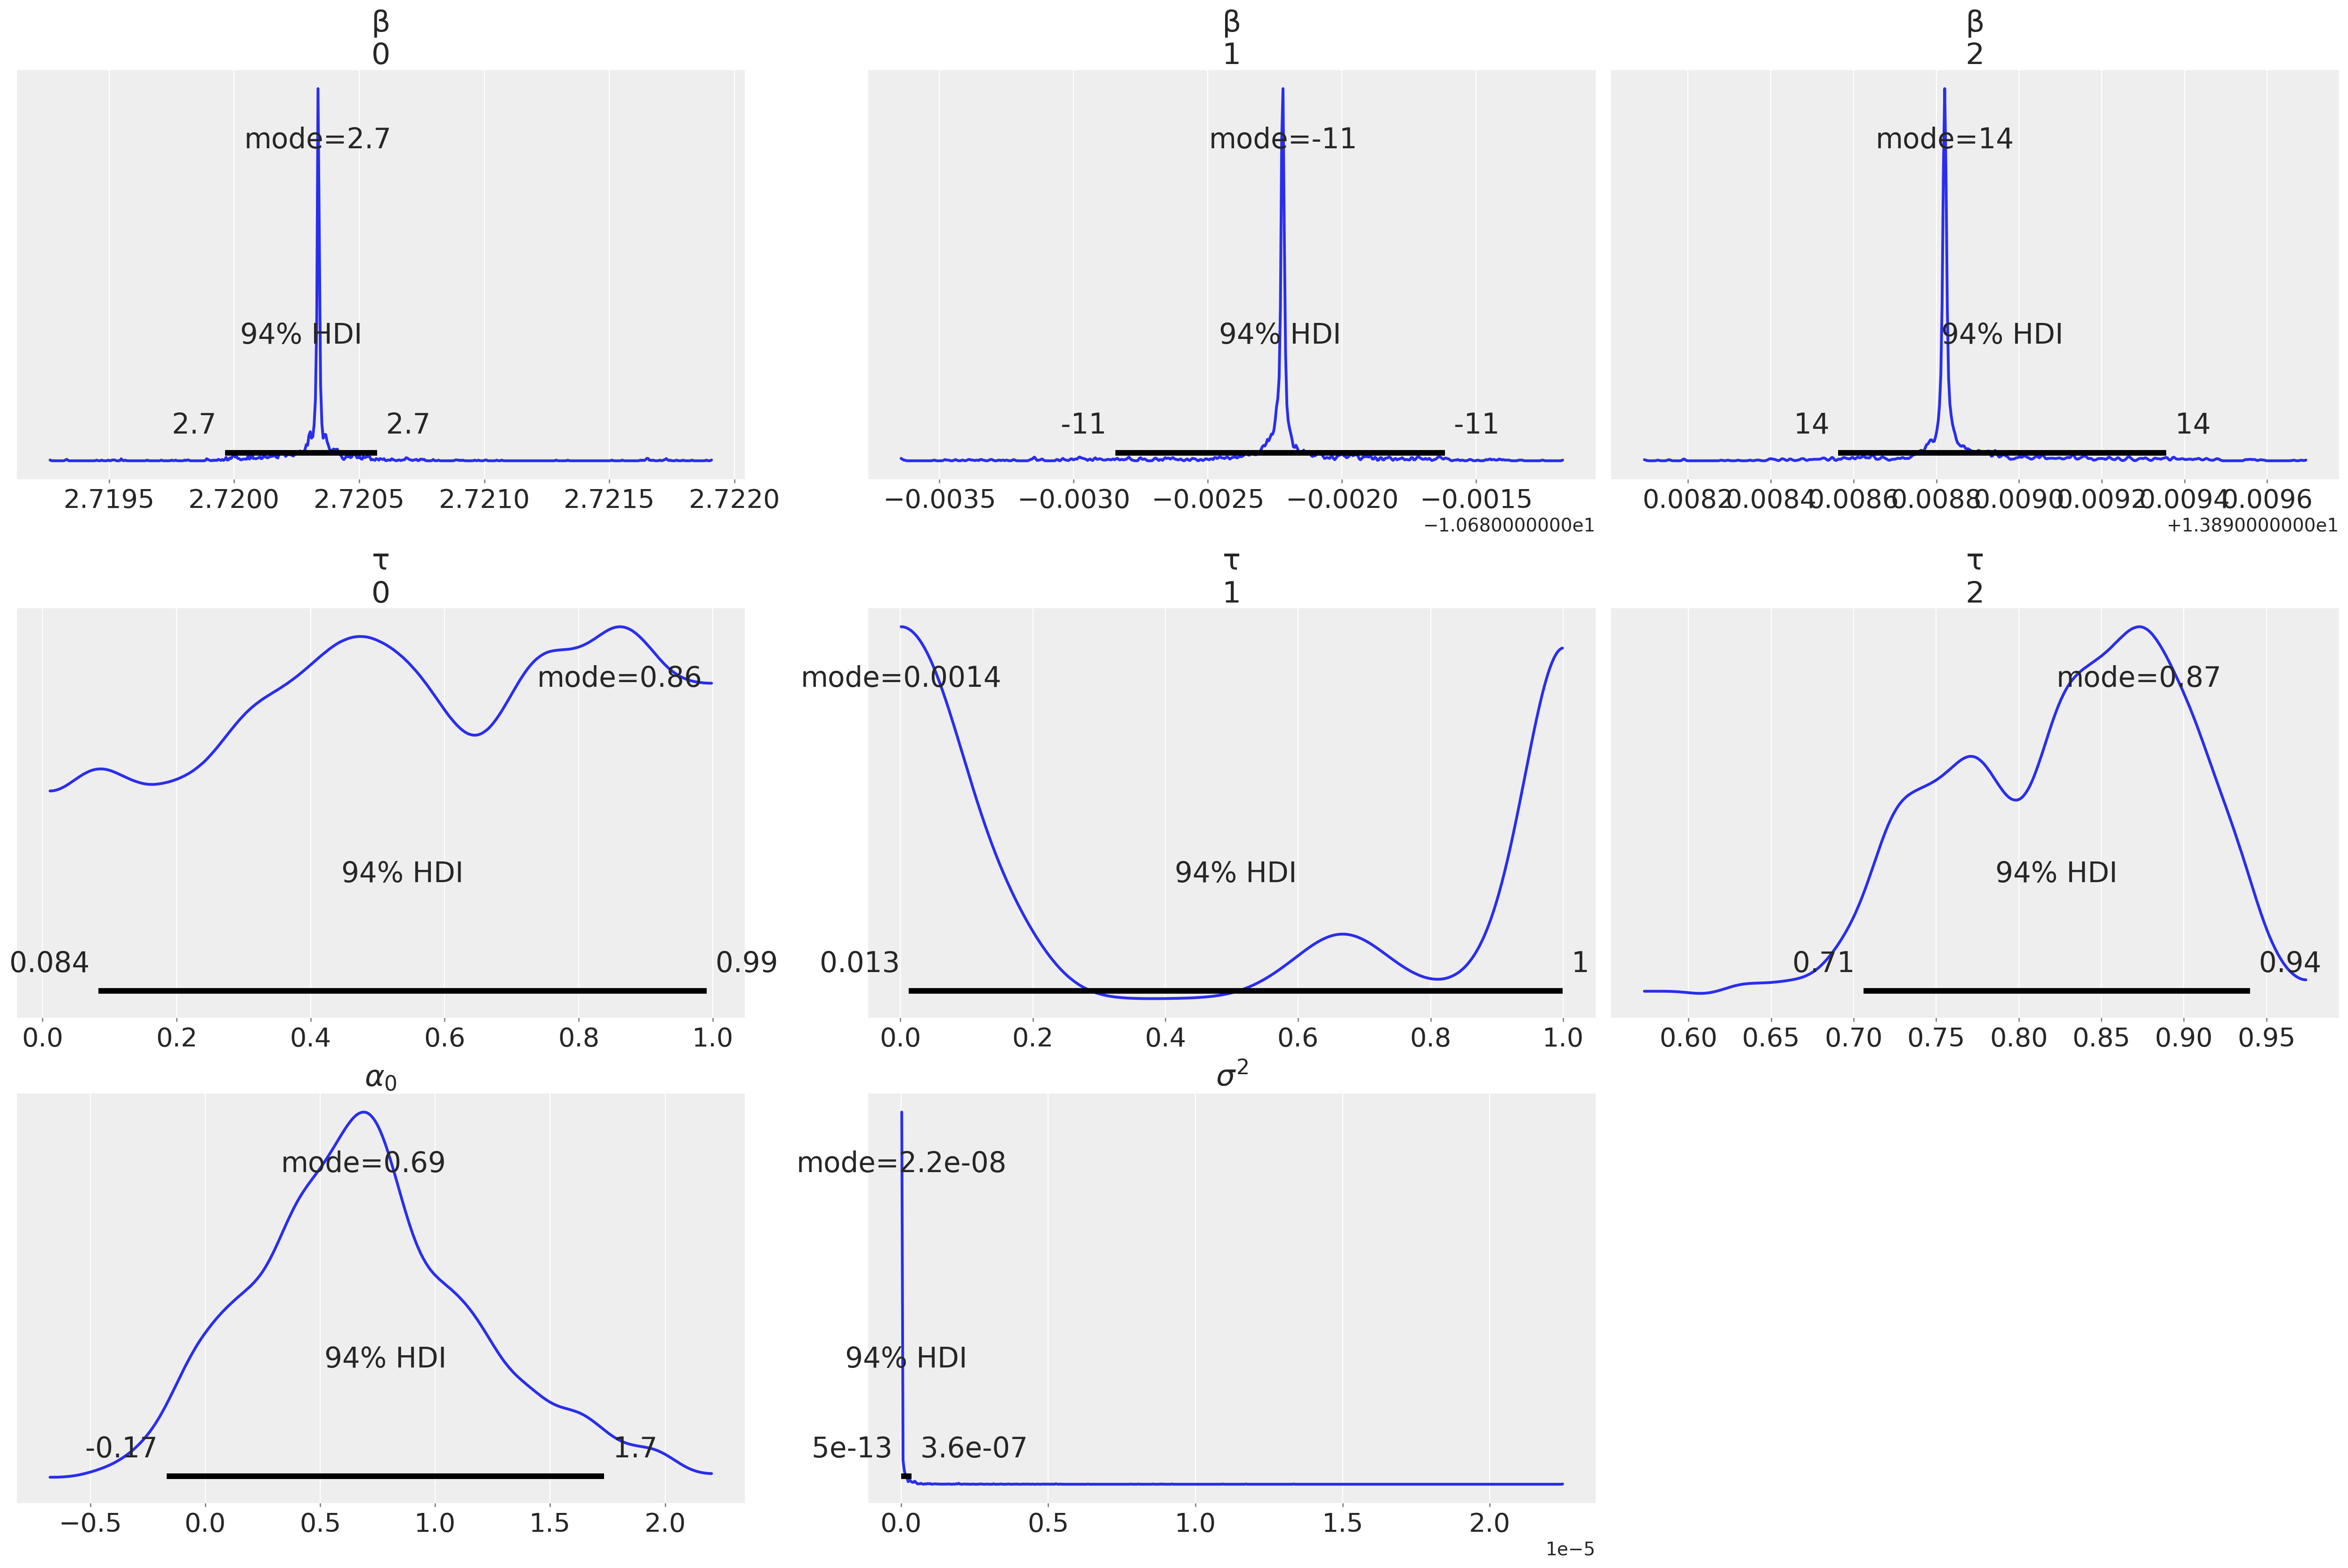

In [46]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


bpv [min] = 1.000
bpv [max] = 1.000
bpv [median] = 1.000
bpv [mean] = 0.539
bpv [std] = 0.587


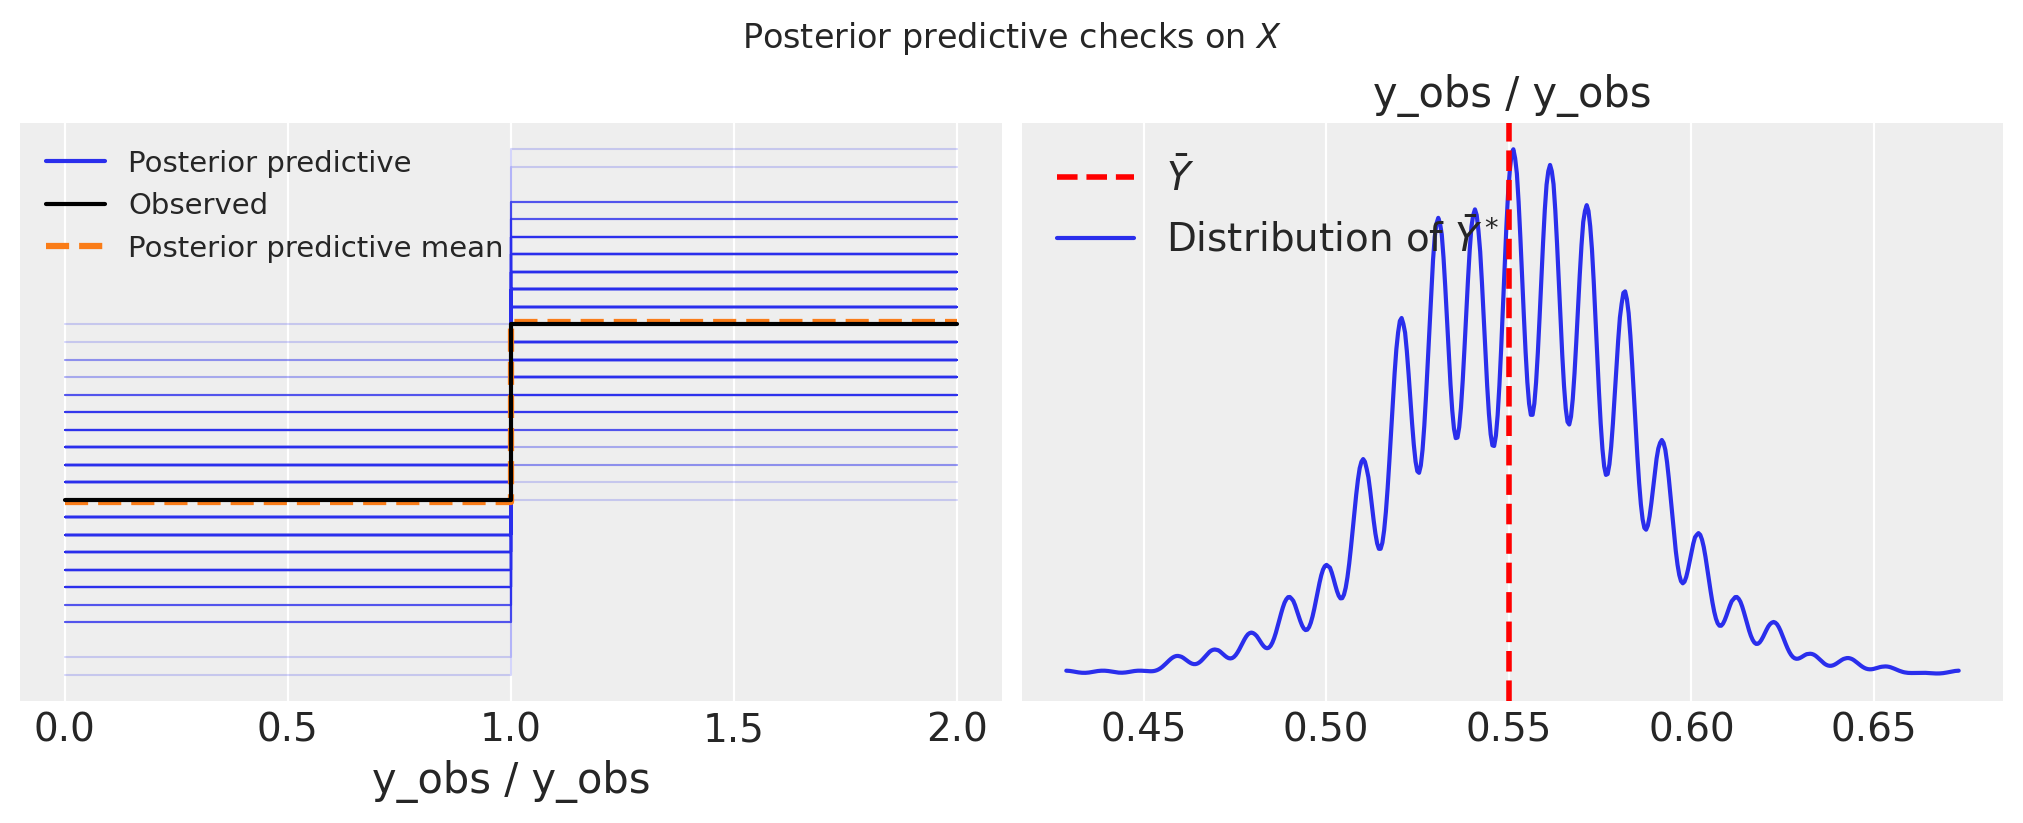

In [47]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    ppc = pm.sample_posterior_predictive(idata_pymc)
    idata_pymc.extend(az.from_pymc3(posterior_predictive=ppc))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
utils.plot_ppc(idata_pymc, n_samples=500, ax=axs[0])
az.plot_bpv(idata_pymc, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y^*$")])
_ = axs[1].legend(handles=handles)
plt.suptitle(r"Posterior predictive checks on $X$")

for name, stat in statistics:
    bpv = utils.bpv(ppc['y_obs'], Y, stat)
    print(f"bpv [{name}] = {bpv:.3f}")

In [ ]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


bpv [min] = 1.000
bpv [max] = 1.000
bpv [median] = 1.000
bpv [mean] = 0.937
bpv [std] = 0.119


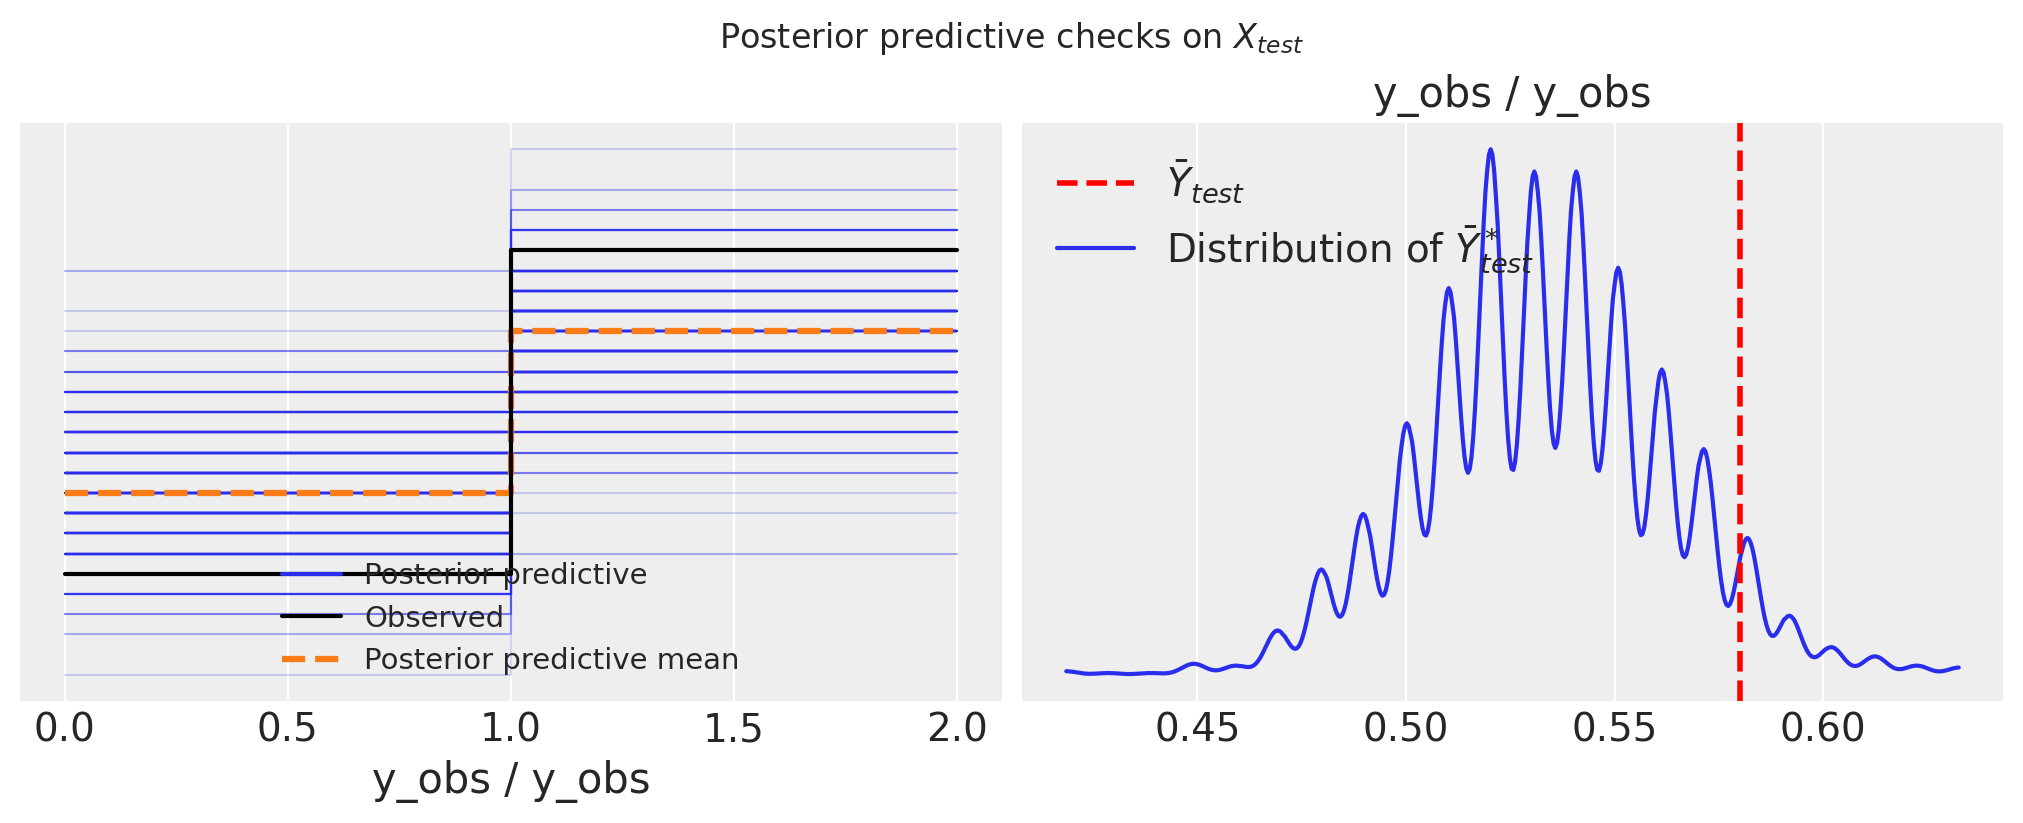

In [48]:
# -- Generate and plot posterior predictive samples from X_test

model_test = make_model(p_hat, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    ppc_test = pm.sample_posterior_predictive(idata_pymc)
    idata_ppc_test = az.from_pymc3(posterior_predictive=ppc_test)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
utils.plot_ppc(idata_ppc_test, n_samples=500, ax=axs[0])
az.plot_bpv(idata_ppc_test, kind='t_stat', t_stat='mean',
            plot_mean=False, ax=axs[1], bpv=False)
axs[1].axvline(Y_test.mean(), ls="--",
               color="r", lw=2, label=r"$\bar Y_{test}$")
handles, labels = axs[1].get_legend_handles_labels()
handles.extend([Line2D([0], [0], label=r"Distribution of $\bar Y_{test}^*$")])
_ = axs[1].legend(handles=handles)
plt.suptitle(r"Posterior predictive checks on $X_{test}$")

for name, stat in statistics:
    bpv = utils.bpv(ppc_test['y_obs'], Y_test, stat)
    print(f"bpv [{name}] = {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters.

In [49]:
# -- Compute metrics using several point estimates

point_estimates = ["mode", "mean", "median"]
df_metrics_pymc = pd.DataFrame(columns=results_columns)

# Posterior mean estimate
Y_hat = [utils.threshold(y) 
         for y in ppc_test['y_obs'][::thin_ppc, :].mean(axis=0)]
metrics = utils.classification_metrics(Y_test, Y_hat)
df_metrics_pymc.loc[0] = [
    "pymc_posterior_mean",
    p_hat,
    metrics["acc"],
]

# Point estimates
for i, pe in enumerate(point_estimates):
    Y_hat = utils.point_predict(
        X_test, idata_pymc,
        theta_names, pe, kind='classification')
    metrics = utils.classification_metrics(Y_test, Y_hat)
    df_metrics_pymc.loc[i + 1] = [
        "pymc_" + pe,
        p_hat,
        metrics["acc"],
    ]

df_metrics_pymc.sort_values(results_columns[-1], inplace=True, ascending=False)
df_metrics_pymc.style.hide_index()

In [50]:
# -- Test variable selection procedure

bayesian_varsel(idata_pymc, theta_space, theta_names, X_fd,
                Y, X_test_fd, Y_test, folds, prefix="pymc",
                point_est='mode')

 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:Liblinear failed to converge, increase the number of iterations.


Estimator Features  Accuracy
1   pymc_mode+sk_svm_lin        3      0.96
0  pymc_mode+sk_logistic        3      0.94
2   pymc_mode+sk_svm_rbf        3      0.92

### Save & Load

In [ ]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [ ]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 18 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

pandas    : 1.3.3
theano    : 1.1.2
emcee     : 3.1.1
matplotlib: 3.4.3
json      : 2.0.9
pymc3     : 3.11.4
numpy     : 1.20.3
autopep8  : 1.5.7
scipy     : 1.7.1
skfda     : 0.0
sys       : 3.9.7 (default, Oct 10 2021, 15:13:22) 
[GCC 11.1.0]
arviz     : 0.11.4
logging   : 0.5.1.2

Watermark: 2.2.0

